# Imports

In [ ]:
import os
from math import isnan

import numpy as np
# from ds_aws_services.athena_api  import cachedAthenaApi
from ds_aws_services import CachedAthenaApi
import pandas as pd

import generic_enrich_modeling
# from datetime import datetime, timedelta

os.environ['disk_caching'] = 'true'
import matplotlib.pyplot as plt

# importing the pipeline and models
import importlib
import generic_enrich_modeling
from generic_enrich_modeling import run_partner_analysis    
importlib.reload(generic_enrich_modeling)

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

<module 'generic_enrich_modeling' from '/Users/omri.bouchnick/Documents/GitHub/enrichment/generic_enrich_modeling.py'>

# Sofi

In [2]:
product_id = 13909
vertical_id = '60cb9343d2882671782f4a63'
clickout_date_prt = '2025-01-01'

In [ ]:
def query_sofi_func() -> pd.DataFrame:  #run_id_prt:str
    query_sofi = f"""
With enrichmen_final AS (
                                       SELECT  
                                               f.partner_id as en_partner_id,
                                               visit_iid as e_visit_iid,
                                               channel_click_id as e_channel_click_id,
                                               SUM(CASE WHEN (f.campaign_name = 'First Deposit' or event_type = 'First Deposit')
                                                           THEN f.sale_amount END)      AS first_deposit_amount,
                                               COUNT(distinct CASE WHEN (f.campaign_name = 'First Deposit' or event_type = 'First Deposit')
                                                                      THEN subid END) AS first_deposit_counts
                                        FROM dlk_visitor_funnel_dwh_production.enrich_conversions_flatten f
                                             left join dlk_visitor_funnel_dwh_production.chart_funnel c
                                        on f.subid = c.cid
                                        where transaction_month_prt >= '2025-01'
                                          And f.vertical_id = '{vertical_id}'
                                          AND deal_type = 'Sale'
                                          and f.item_name like '%SoFi%'
                                          and f.ad in ('Natural Intelligence: SoFi Checking (1786733)','SoFi Plus_Banking (2225300)','NI Mobile Traffic: SoFi Checking & Savings (1869324)','Natural Intelligence: SoFi Savings (1786738)')
                                          and rn = 1
                                          and c.vertical_id = '{vertical_id}'
                                          and c.product_id = {product_id}
                                        group by 1, 2, 3
                                        having sum(f.sale_amount) >0
                                        ),
     prediction_data AS (
                       SELECT   channel_click_id,
                                visit_iid,
                                partner_id,
                                product_name,
                                partner_name,
                                model_version,
                                model_id,
                                traffic_join as channel,
                                coalesce(source_join, utm_source) as source,
                                company,
                                site_name,
                                bucket_group,
                                campaign_name as campaign,
                                ad_group_name,
                                match_type,
                                agent_browser,
                                agent_platform,
                                coalesce(channel_country_code, country_code) as country_code,
                                coalesce(channel_region_code,ip_region_code) as region_code,
                                clickout_timestamp,
                                model_run_id,
                                run_id_prt,
                                out_type,
                                page_type_name,
                                row_number () over (partition by visit_iid order by clickout_timestamp desc) as rn,
                                max(gclid) as gclid,
                                max(topic) as topic,
                                max(ppc_account_name) as ppc_account_name,
                                max(landing_page_uri) as landing_page_uri,
                                max(traffic_source_name) as traffic_source_name,
                                max(pli_segment_name) as pli_segment_name,
                                max(agent_os) as agent_os,
                                max(pli_vertical_name) as pli_vertical_name,
                                min(conversion_month_prt) as conversion_month_prt,
                                min(clickout_date_prt) clickout_date_prt,
                                min (visit_timestamp) AS visit_timestamp,
                                max (normalized_p_cr_lead) AS normalized_p_cr_lead,
                                Max (avg_conversion_lag_sale) AS avg_conversion_lag_sale,
                                max (normalized_p_cr_sale) AS normalized_p_cr_sale,
                                min (p_conversion_time_sale) AS p_conversion_time_sale,
                                Max (predicted_commission) AS predicted_commission,
                                max (estimated_earnings_usd) AS estimated_earnings_usd,
                                max (estimated_conversions) AS estimated_conversions,
                                max (conversion_count) AS conversion_count,
                                max (leads_count) AS leads_count,
                                max (qualified_leads_count) AS qualified_leads_count,
                                max (sales_count) AS sales_count
FROM dlk_mlmodels_production.v_multilabel_conversions_predictions_fast_longer
WHERE product_id = {product_id}
  AND vertical_id = '{vertical_id}'
  AND clickout_date_prt >= '{clickout_date_prt}'
group by 1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
    )
select *
from prediction_data as p
         inner join enrichmen_final as en
              on (p.channel_click_id = en.e_channel_click_id and p.visit_iid = en.e_visit_iid)
where sales_count > 0
and first_deposit_counts > 0
"""
    raw = CachedAthenaApi().execute_fetch(query_sofi)
    df_enrich_sofi = pd.DataFrame(raw)
    return df_enrich_sofi

df_enrich_sofi = query_sofi_func()
print(df_enrich_sofi.head())

In [ ]:
print(df_enrich_sofi.size)
sofi_only_sales = df_enrich_sofi.loc[df_enrich_sofi['sales_count'] > 0]
print(sofi_only_sales.size)

In [ ]:
(sofi_only_sales.first_deposit_amount.describe())

In [ ]:
sofi_only_sales.columns

In [ ]:
sofi_only_sales[['visit_iid', 'sales_count','first_deposit_amount','first_deposit_counts','conversion_count','leads_count','normalized_p_cr_lead','normalized_p_cr_sale']]

some sales without conversion - visit_iid = 'tvfj69l6X18Osu240hc9'
some sales without lead - '3EXyi3IDCDWI80797fpb' . they are also without payout



In [8]:
sofi_only_sales.drop(columns=['partner_id', 'partner_name'], inplace=True)


In [ ]:
# Missing values
missing = sofi_only_sales.isna().mean().sort_values(ascending=False)
display(missing[missing > 0])

# Duplicate visit_iid rows?
dupes = sofi_only_sales["visit_iid"].duplicated().sum()
print(f"Duplicate visit_iid rows: {dupes}")

# Basic numeric ranges
sofi_only_sales.describe().T

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
# Replace 'deposit' with your actual target column name
sofi_only_sales['first_deposit_amount'].hist(bins=50, grid=False) 
plt.title("Deposit Distribution")
plt.xlabel("Deposit Amount")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Select only numeric columns for correlation
numeric_df = sofi_only_sales.select_dtypes(include=np.number)
corr = numeric_df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr, cmap='coolwarm')
fig.colorbar(cax)

# Set up axes to show all labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

plt.title("Feature Correlation Matrix")
plt.show()

In [12]:
sofi_only_sales.rename(
    columns={'first_deposit_amount': 'deposit'},
    inplace=True
)

In [13]:
# Replace with your actual list of categorical column names
# categorical_cols = sofi_only_sales.select_dtypes(include=['object', 'category']).columns
categorical_cols = ['campaign','ad_group_name','match_type','agent_browser','agent_os','country_code',
                     'region_code','country_code', 'region_code'
    , 'out_type', 'page_type_name', 'topic', 'traffic_source_name',
       'ppc_account_name', 'landing_page_uri',
       'pli_segment_name', 'pli_vertical_name','conversion_month_prt']

In [ ]:
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import numpy as np

# Make sure 'categorical_cols' is defined, e.g.:
# categorical_cols = sofi_only_sales.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    
    # --- For high-cardinality columns, use a bubble chart ---
    if sofi_only_sales[col].nunique() > 7:
        print(f"--- Bubble Chart for {col} (High Cardinality) ---")
        
        # 1. Aggregate data to get median deposit and total sales per category
        # NOTE: Assumes a 'sales_count' column exists for bubble size. Change if needed.
        summary_df = sofi_only_sales.groupby(col).agg(
            median_deposit=('deposit', 'median'),
            total_sales=('sales_count', 'sum') 
        ).sort_values('total_sales', ascending=False)

        # To keep the plot readable, let's only show the top 50 categories
        if len(summary_df) > 50:
            summary_df = summary_df.head(50)
            print(f"Warning: Displaying only top 50 categories for '{col}' sorted by total sales.")
            
        # 2. Prepare data for plotting
        x_labels = summary_df.index
        y_values = summary_df['median_deposit']
        # Scale bubble sizes for better visibility. You can adjust the multiplier.
        bubble_sizes = summary_df['total_sales'] * 0.5 
        colors = np.arange(len(summary_df))

        # 3. Create the plot
        plt.figure(figsize=(16, 8))
        scatter = plt.scatter(x=x_labels, y=y_values, s=bubble_sizes, c=colors, cmap='viridis', alpha=0.7, zorder=2)
        
        plt.xticks(rotation=90)
        plt.xlabel(col)
        plt.ylabel("Median Deposit Amount")
        plt.title(f"Median Deposit vs. Total Sales by {col}", fontsize=16)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        # Create a legend for bubble sizes by plotting invisible points
        for sales in [summary_df['total_sales'].min(), summary_df['total_sales'].median(), summary_df['total_sales'].max()]:
             plt.scatter([], [], s=sales * 0.5, label=f'{int(sales)} sales', c='gray', alpha=0.5)
        plt.legend(scatterpoints=1, frameon=False, labelspacing=1.5, title='Total Sales Volume')

        plt.tight_layout()
        plt.show()

    # --- For low-cardinality columns, use a sorted boxplot ---
    else:
        print(f"--- Sorted Boxplot for {col} (Low Cardinality) ---")
        
        # 1. Get the category order, sorted by frequency (count)
        sorted_order = sofi_only_sales[col].value_counts().index
        
        # 2. Use a temporary copy for plotting to avoid changing original DataFrame
        plot_df = sofi_only_sales.copy()
        cat_type = CategoricalDtype(categories=sorted_order, ordered=True)
        plot_df[col] = plot_df[col].astype(cat_type)
        
        # 3. Create the sorted boxplot
        plot_df.boxplot(column='deposit', by=col, figsize=(10, 6), grid=False)
        plt.title(f"Deposit Distribution by {col}", fontsize=16)
        plt.suptitle("") # Remove default title
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Deposit Amount")
        plt.xlabel(col)
        
        plt.tight_layout()
        plt.show()

In [15]:
# import sys
# print(sys.executable)

# import seaborn as sns
# print(sns.__version__)


In [ ]:
for col in categorical_cols:
    sofi_only_sales.boxplot(column='deposit', by=col, figsize=(8, 5), grid=False)
    plt.title(f"Deposit by {col}")
    plt.suptitle("")  # Removes the automatic title to avoid clutter
    plt.xticks(rotation=45)
    plt.ylabel("Deposit Amount")
    plt.show()

In [ ]:
## Deposit >= 5000
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming 'sofi_only_sales' DataFrame and 'categorical_cols' list are defined

# Create a temporary helper column for deposits >= 5000
sofi_only_sales['is_high_deposit'] = (sofi_only_sales['deposit'] >= 5000).astype(int)

for col in categorical_cols:
    print(f"--- High-Value Deposit Analysis for {col} ---")

    # 1. Aggregate data to get counts and totals for each category
    summary_df = sofi_only_sales.groupby(col).agg(
        high_deposit_count=('is_high_deposit', 'sum'),
        total_count=('deposit', 'count')
    ).reset_index()

    # Avoid division by zero for categories with no sales
    summary_df = summary_df[summary_df['total_count'] > 0]
    
    # 2. Calculate the ratio
    summary_df['high_deposit_ratio'] = summary_df['high_deposit_count'] / summary_df['total_count']

    # 3. Sort by the raw count of high-value deposits to see the biggest contributors first
    summary_df = summary_df.sort_values('high_deposit_count', ascending=False)
    
    # Limit to top 40 categories to keep the chart readable if there are too many
    if len(summary_df) > 40:
        summary_df = summary_df.head(40)
        print(f"Note: Displaying only top 40 of {len(summary_df)} categories for '{col}' (sorted by high deposit count).")

    # 4. Create the dual-axis plot
    fig, ax1 = plt.subplots(figsize=(15, 7))

    # Left Y-axis (ax1): Bar chart for the raw counts
    ax1.bar(summary_df[col], summary_df['high_deposit_count'], color='cornflowerblue', label='Count of Deposits >= $5000')
    ax1.set_ylabel('Count of Deposits >= $5000', color='cornflowerblue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='cornflowerblue')
    ax1.tick_params(axis='x', rotation=90)
    ax1.set_xlabel(col, fontsize=12)
    
    # Right Y-axis (ax2): Line plot for the ratio
    ax2 = ax1.twinx()
    ax2.plot(summary_df[col], summary_df['high_deposit_ratio'], color='tomato', marker='o', linestyle='--', label='Ratio of High-Value Deposits')
    ax2.set_ylabel('Ratio of Deposits >= $5000', color='tomato', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='tomato')
    # Format the ratio axis as a percentage
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    
    # Set a sensible upper limit for the percentage axis
    ax2.set_ylim(0, max(summary_df['high_deposit_ratio'].max() * 1.1, 0.1))

    plt.title(f'High-Value Deposits Analysis by {col}', fontsize=16)
    fig.tight_layout() # Adjust plot to prevent labels from overlapping
    plt.show()

# Clean up the temporary column after the loop is done
sofi_only_sales.drop(columns=['is_high_deposit'], inplace=True)

### FEATURE ENGINEERING: 

In [ ]:
sofi_only_sales.columns

In [19]:
# sofi_only_sales = sofi_only_sales.drop(columns=['deposit_binary', 'campaign_ad_group', 'is_weekend', 'hour_of_day'])

# Add these features to improve classification performance
# sofi_only_sales['deposit_binary'] = (sofi_only_sales['deposit'] >= 5000).astype(int)

# Create interaction features
if {'campaign', 'ad_group_name'}.issubset(sofi_only_sales.columns):
    sofi_only_sales['campaign_ad_group'] = sofi_only_sales['campaign'] + '_' + sofi_only_sales['ad_group_name']

# Add temporal features if you have date columns
if 'clickout_date_prt' in sofi_only_sales.columns:
    # Convert to datetime first
    sofi_only_sales['clickout_date_prt'] = pd.to_datetime(sofi_only_sales['clickout_date_prt'])
    sofi_only_sales['is_weekend'] = (sofi_only_sales['clickout_date_prt'].dt.dayofweek >= 5).astype(int)
    sofi_only_sales['hour_of_day'] = sofi_only_sales['clickout_date_prt'].dt.hour    

In [ ]:
# List of columns to remove based on our full analysis
cols_to_drop = [
    'country_code',        # low variance
    'outtype',             # low variance
    'pli_vertical_name',   # only 1 vertical - low variance
    'agent_browser',       # Low predictive power
    'page_type_name',      # Low predictive power
    'conversion_month_prt', # Removing due to concept drift concerns - data is better from april 2025
    # 3. High-cardinality ID columns (as you correctly identified)
    'visit_iid', # Too many unique values
    'channel_click_id', # Too many unique values
    'gclid', # Too many unique values
    'e_channel_click_id', # Too many unique values
    'leads_count','sales_count','en_partner_id','conversion_count', # all data is sales already.. 
    'e_visit_iid','en_channel_click_id','qualified_leads_count',
    'run_id_prt','out_type','gclid','clickout_timestamp',
    'normazlied_p_cr_lead','estimated_earnings_usd','estimated_conversions',
    'first_deposit_counts' 
    ,'normalized_p_cr_sale'
    ,'normalized_p_cr_lead'
    ,'clickout_date_prt'
    , 'qualified_leads_count'
    ,'model_version'
    ,'model_id'
    ,'model_run_id'
    ,'clickout_timestamp'

    ]

# Make sure to only drop columns that actually exist in the DataFrame
existing_cols_to_drop = [col for col in cols_to_drop if col in sofi_only_sales.columns]

print(f"Removing the following columns to create the final modeling dataset: \n{existing_cols_to_drop}")


In [ ]:
# Create the final DataFrame for our first model
sofi_model_df = sofi_only_sales.drop(columns=existing_cols_to_drop)

print("\n--- Columns remaining for Model 1 (trained on all data) ---")
print(sofi_model_df.columns.to_list())

#### Preprocessing

In [ ]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "category_encoders"])

In [ ]:
# ============================================================================
# UPGRADED COMPREHENSIVE PIPELINE
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform
import warnings
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

print("=== STEP 1: ENHANCED DATA PREPROCESSING ===")

# 1.1 Target transformation (log1p for skewed deposits)
print("\n1.1 Target Transformation:")
print(f"Original deposit skew: {sofi_model_df['deposit'].skew():.2f}")
sofi_model_df['deposit_log'] = np.log1p(sofi_model_df['deposit'])
print(f"Log-transformed deposit skew: {sofi_model_df['deposit_log'].skew():.2f}")

# 1.2 Create interaction features
print("\n1.2 Creating Interaction Features:")
if {'sales_count', 'deposit'}.issubset(sofi_model_df.columns):
    sofi_model_df['avg_deposit_per_sale'] = sofi_model_df['deposit'] / (sofi_model_df['sales_count'] + 1e-6)
    print("Created: avg_deposit_per_sale")

# 1.3 Update feature lists
numeric_features = sofi_model_df.select_dtypes(include=['number']).columns.drop(['deposit', 'deposit_log'])
categorical_features = sofi_model_df.select_dtypes(include=['object', 'category']).columns

print(f"Final numeric features: {len(numeric_features)}")
print(f"Final categorical features: {len(categorical_features)}")

# 1.4 Split data with log target
X = sofi_model_df.drop(['deposit', 'deposit_log'], axis=1)
y_original = sofi_model_df['deposit']
y_log = sofi_model_df['deposit_log']

X_train, X_test, y_train_orig, y_test_orig, y_train_log, y_test_log = train_test_split(
    X, y_original, y_log, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

In [ ]:
sofi_model_df.columns

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder


print("\n=== STEP 2: MULTIPLE PREPROCESSORS & MODELS ===")

# 2.1 Create two preprocessing strategies
preprocessor_standard = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)  # Add sparse_output=False
    ],
    remainder='drop'
)

# 2.2 Create multiple models
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=200, max_depth=10, min_samples_leaf=5,
        random_state=42, n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, random_state=42
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_iter=600, learning_rate=0.05, max_depth=6,
        l2_regularization=0.1, random_state=42
    ),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.01, random_state=42)
}

print("Created 5 different models for comparison")

In [ ]:
from sklearn.pipeline import Pipeline


print("\n=== STEP 3: COMPREHENSIVE MODEL EVALUATION ===")

def evaluate_models_with_multiple_metrics(models_dict, X_train, X_test, y_train, y_test, preprocessor):
    """Evaluate models with multiple metrics"""
    results = {}
    
    for name, model in models_dict.items():
        print(f"\n--- Training {name} ---")
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
        
        # Store results
        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape,
            'MSE': mse,
            'pipeline': pipeline
        }
        
        print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.1f}%")
    
    return results

# Evaluate with standard preprocessing
print("\n" + "="*50)
print("EVALUATION WITH STANDARD PREPROCESSING")
print("="*50)
results_standard = evaluate_models_with_multiple_metrics(models, X_train, X_test, y_train_log, y_test_log, preprocessor_standard)

# Create comparison table
comparison_df = pd.DataFrame()
for name, metrics in results_standard.items():
    comparison_df.loc[name, 'RMSE'] = metrics['RMSE']
    comparison_df.loc[name, 'MAE'] = metrics['MAE']
    comparison_df.loc[name, 'R2'] = metrics['R2']
    comparison_df.loc[name, 'MAPE'] = metrics['MAPE']

print("\n" + "="*50)
print("MODEL COMPARISON TABLE")
print("="*50)
print(comparison_df.round(4).sort_values('R2', ascending=False))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


print("\n=== STEP 4: HYPERPARAMETER TUNING ===")

# Find best model
best_model_name = comparison_df['R2'].idxmax()
best_r2 = comparison_df.loc[best_model_name, 'R2']
best_pipeline = results_standard[best_model_name]['pipeline']

print(f"🏆 Best Model: {best_model_name} (R²: {best_r2:.4f})")

# Define hyperparameter search space based on best model
if 'RandomForest' in best_model_name:
    param_dist = {
        'regressor__n_estimators': randint(100, 500),
        'regressor__max_depth': [5, 10, 15, 20, None],
        'regressor__min_samples_leaf': randint(2, 20),
        'regressor__max_features': ['sqrt', 'log2', 1.0]
    }
elif 'GradientBoosting' in best_model_name:
    param_dist = {
        'regressor__n_estimators': randint(200, 600),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__max_depth': randint(3, 10),
        'regressor__subsample': uniform(0.6, 0.4)
    }
elif 'HistGradientBoosting' in best_model_name:
    param_dist = {
        'regressor__max_iter': randint(300, 1000),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__max_depth': randint(3, 10),
        'regressor__l2_regularization': uniform(0.0, 0.5)
    }
else:
    print("No tuning parameters defined for this model type")
    param_dist = {}

if param_dist:
    # Perform randomized search
    random_search_tuned = RandomizedSearchCV(
        estimator=best_pipeline,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    random_search_tuned.fit(X_train, y_train_log)
    
    print(f"Best parameters: {random_search_tuned.best_params_}")
    print(f"Best CV score: {-random_search_tuned.best_score_:.4f}")
    
    # Final evaluation of tuned model
    tuned_pipeline = random_search_tuned.best_estimator_
    y_pred_tuned = tuned_pipeline.predict(X_test)
    final_r2 = r2_score(y_test_log, y_pred_tuned)
    final_rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_tuned))
    
    print(f"\n🎯 Final Tuned Model Performance:")
    print(f"R²: {final_r2:.4f}")
    print(f"RMSE: {final_rmse:.4f}")

In [ ]:
print("\n=== STEP 5: SKIPPING REGRESSION FEATURE IMPORTANCE ===")
print("Moving to classification pipeline which is more relevant for your use case.")

print("\n" + "="*60)
print("STRATEGY CHANGE: R² IS LOW - SWITCHING TO CLASSIFICATION")
print("Predicting: Big Deposits (≥ $5000) YES/NO")
print("="*60)

# 6.1 Create binary target
sofi_model_df['deposit_binary'] = (sofi_model_df['deposit'] >= 5000).astype(int)
print(f"\nBig deposit distribution:")
print(f"Big deposits (≥ $5000): {sofi_model_df['deposit_binary'].sum()} ({sofi_model_df['deposit_binary'].mean()*100:.1f}%)")
print(f"Small deposits (< $5000): {(sofi_model_df['deposit_binary'] == 0).sum()} ({(sofi_model_df['deposit_binary'] == 0).mean()*100:.1f}%)")

# 6.2 Split data for classification
X_clf = sofi_model_df.drop(['deposit', 'deposit_log', 'deposit_binary'], axis=1)  # Remove deposit_binary!
y_clf = sofi_model_df['deposit_binary']  # This is your target

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f"\nClassification dataset:")
print(f"Training set: {X_train_clf.shape[0]} samples")
print(f"Test set: {X_test_clf.shape[0]} samples")
print(f"Class balance in training: {y_train_clf.mean():.3f} big deposits")

In [29]:
# print("\n=== STEP 5: FEATURE IMPORTANCE ANALYSIS ===")

# # Use the best model (tuned or original)
# best_pipeline_for_importance = tuned_pipeline if 'tuned_pipeline' in locals() else best_pipeline

# # Permutation importance
# perm_importance = permutation_importance(
#     best_pipeline_for_importance, X_train, y_train_log, 
#     n_repeats=10, random_state=42, n_jobs=-1
# )

# # Get feature names from preprocessor
# feature_names_out = best_pipeline_for_importance.named_steps['preprocessor'].get_feature_names_out()

# # Debug: Check lengths
# print(f"Feature names length: {len(feature_names_out)}")
# print(f"Importance array length: {len(perm_importance.importances_mean)}")

# # Ensure arrays have same length
# min_length = min(len(feature_names_out), len(perm_importance.importances_mean))
# feature_names_out = feature_names_out[:min_length]
# perm_importance.importances_mean = perm_importance.importances_mean[:min_length]
# perm_importance.importances_std = perm_importance.importances_std[:min_length]

# # Create importance dataframe
# importance_df = pd.DataFrame({
#     'feature': feature_names_out,
#     'importance': perm_importance.importances_mean,
#     'std': perm_importance.importances_std
# }).sort_values('importance', ascending=False)

# print("Top 20 Most Important Features:")
# print(importance_df.head(20))

# # Plot feature importance
# plt.figure(figsize=(12, 8))
# top_features = importance_df.head(20)
# plt.barh(range(len(top_features)), top_features['importance'])
# plt.yticks(range(len(top_features)), top_features['feature'])
# plt.xlabel('Permutation Importance')
# plt.title('Top 20 Feature Importances')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

### Changing Target to Big Deposits (>5000$) (yes/no) 

In [30]:
# import sys, subprocess
# subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "seaborn"])

In [ ]:
print("\n" + "="*60)
print("STRATEGY CHANGE: R² IS LOW - SWITCHING TO CLASSIFICATION")
print("Predicting: Big Deposits (≥ $5000) YES/NO")
print("="*60)

# 6.1 Create binary target
sofi_model_df['deposit_binary'] = (sofi_model_df['deposit'] >= 5000).astype(int)

# 4. IMPORTANT: Update X to EXCLUDE the target variable
X_clf = sofi_model_df.drop(['deposit', 'deposit_log', 'deposit_binary'], axis=1)  # Remove deposit_binary!
y_clf = sofi_model_df['deposit_binary']  # This is your target

# 5. Split the data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f"Features shape: {X_clf.shape}")
print(f"Target distribution: {y_clf.value_counts()}")
print(f"Training set: {X_train_clf.shape[0]} samples")
print(f"Test set: {X_test_clf.shape[0]} samples")

In [ ]:
print("\n=== STEP 7: CLASSIFICATION MODELS ===")

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

# 7.1 Create classification models
clf_models = {
    'RandomForest_Clf': RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_leaf=5,
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'GradientBoosting_Clf': GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, random_state=42
    ),
    'HistGradientBoosting_Clf': HistGradientBoostingClassifier(
        max_iter=600, learning_rate=0.05, max_depth=6,
        l2_regularization=0.1, random_state=42
    ),
    'LogisticRegression_Clf': LogisticRegression(
        C=1.0, class_weight='balanced', random_state=42, max_iter=1000
    )
}

# 7.2 Evaluation function for classification
def evaluate_classification_models(models_dict, X_train, X_test, y_train, y_test, preprocessor):
    """Evaluate classification models with multiple metrics"""
    results = {}
    
    for name, model in models_dict.items():
        print(f"\n--- Training {name} ---")
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'Accuracy': accuracy,
            'ROC_AUC': roc_auc,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'pipeline': pipeline,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"{name} - Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    return results

# 7.3 Evaluate classification models
print("\n" + "="*50)
print("CLASSIFICATION MODEL EVALUATION")
print("="*50)

# Use the same preprocessor but with sparse_output=False for classification
preprocessor_clf = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

clf_results = evaluate_classification_models(clf_models, X_train_clf, X_test_clf, y_train_clf, y_test_clf, preprocessor_clf)

# 7.4 Create classification comparison table
clf_comparison_df = pd.DataFrame()
for name, metrics in clf_results.items():
    clf_comparison_df.loc[name, 'Accuracy'] = metrics['Accuracy']
    clf_comparison_df.loc[name, 'ROC_AUC'] = metrics['ROC_AUC']
    clf_comparison_df.loc[name, 'Precision'] = metrics['Precision']
    clf_comparison_df.loc[name, 'Recall'] = metrics['Recall']
    clf_comparison_df.loc[name, 'F1_Score'] = metrics['F1_Score']

print("\n" + "="*50)
print("CLASSIFICATION MODEL COMPARISON")
print("="*50)
print(clf_comparison_df.round(4).sort_values('ROC_AUC', ascending=False))

In [ ]:
# Tune the Logistic Regression
## Cell 8.1? needed? 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist_lr = {
    'classifier__C': uniform(0.1, 10.0),
    'classifier__class_weight': ['balanced', None],
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__solver': ['liblinear', 'saga']
}

# Get the best classification pipeline first
best_clf_name = clf_comparison_df['ROC_AUC'].idxmax()
best_clf_pipeline = clf_results[best_clf_name]['pipeline']


random_search_lr = RandomizedSearchCV(
    estimator=best_clf_pipeline,
    param_distributions=param_dist_lr,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_lr.fit(X_train_clf, y_train_clf)
print(f"Best parameters: {random_search_lr.best_params_}")
print(f"Best ROC-AUC: {random_search_lr.best_score_:.4f}")

In [ ]:
# 9. Voting Classifier
# Try voting classifier
from sklearn.ensemble import VotingClassifier

# Create voting classifier with top 3 models
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=1.0, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=300, random_state=42))
    ],
    voting='soft'  # Use probability predictions
)

voting_pipeline = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('classifier', voting_clf)
])

voting_pipeline.fit(X_train_clf, y_train_clf)
y_pred_voting = voting_pipeline.predict(X_test_clf)
y_pred_proba_voting = voting_pipeline.predict_proba(X_test_clf)[:, 1]

print(f"Voting Classifier ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_voting):.4f}")

In [ ]:
print("\n=== STEP 10: BEST CLASSIFICATION MODEL ANALYSIS ===")

# Find best classification model
best_clf_name = clf_comparison_df['ROC_AUC'].idxmax()
best_clf_metrics = clf_results[best_clf_name]
best_clf_pipeline = clf_results[best_clf_name]['pipeline']

print(f"🏆 Best Classification Model: {best_clf_name}")
print(f"ROC-AUC: {best_clf_metrics['ROC_AUC']:.4f}")
print(f"Accuracy: {best_clf_metrics['Accuracy']:.4f}")
print(f"F1-Score: {best_clf_metrics['F1_Score']:.4f}")

# 8.1 Confusion Matrix
y_pred_best = clf_results[best_clf_name]['y_pred']
cm = confusion_matrix(y_test_clf, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Small Deposit', 'Big Deposit'],
            yticklabels=['Small Deposit', 'Big Deposit'])
plt.title(f'Confusion Matrix - {best_clf_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 8.2 Classification Report
print(f"\nClassification Report for {best_clf_name}:")
print(classification_report(y_test_clf, y_pred_best, 
                          target_names=['Small Deposit', 'Big Deposit']))

# 8.3 ROC Curve
from sklearn.metrics import roc_curve
y_pred_proba_best = clf_results[best_clf_name]['y_pred_proba']
fpr, tpr, _ = roc_curve(y_test_clf, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_clf_name} (AUC = {best_clf_metrics["ROC_AUC"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("\n=== STEP 9: CLASSIFICATION FEATURE IMPORTANCE ===")

# Permutation importance for classification
clf_perm_importance = permutation_importance(
    best_clf_pipeline, X_train_clf, y_train_clf, 
    n_repeats=10, random_state=42, n_jobs=-1, scoring='roc_auc'
)

# Get feature names from preprocessor
clf_feature_names_out = best_clf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Ensure arrays have same length
min_length = min(len(clf_feature_names_out), len(clf_perm_importance.importances_mean))
clf_feature_names_out = clf_feature_names_out[:min_length]
clf_perm_importance.importances_mean = clf_perm_importance.importances_mean[:min_length]
clf_perm_importance.importances_std = clf_perm_importance.importances_std[:min_length]

# Create importance dataframe
clf_importance_df = pd.DataFrame({
    'feature': clf_feature_names_out,
    'importance': clf_perm_importance.importances_mean,
    'std': clf_perm_importance.importances_std
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features for Big Deposit Classification:")
print(clf_importance_df.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_clf_features = clf_importance_df.head(20)
plt.barh(range(len(top_clf_features)), top_clf_features['importance'])
plt.yticks(range(len(top_clf_features)), top_clf_features['feature'])
plt.xlabel('Permutation Importance (ROC-AUC)')
plt.title('Top 20 Feature Importances for Big Deposit Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### ?

In [ ]:
# 0.a skew & scale check
numeric = sofi_model_df.select_dtypes('number').drop(columns='deposit')
numeric.skew().sort_values(ascending=False).head(15)

# 0.b feature importance from the RF you trained
import pandas as pd, matplotlib.pyplot as plt

# Get the best regression model from your results
best_model_name = comparison_df['R2'].idxmax()
best_pipeline = results_standard[best_model_name]['pipeline']

# Check if the model has feature_importances_ (tree-based models)
regressor = best_pipeline.named_steps['regressor']
if hasattr(regressor, 'feature_importances_'):
    # Tree-based model (RandomForest, GradientBoosting, etc.)
    fi = pd.Series(regressor.feature_importances_,
                   index = best_pipeline.named_steps['preprocessor']
                                .get_feature_names_out()).sort_values(ascending=False)
    
    fi.head(30).plot(kind='barh', figsize=(7,6))
    plt.gca().invert_yaxis()
    plt.title(f'Feature Importance - {best_model_name}')
    plt.show()
else:
    # Linear model (Lasso, Ridge, LinearRegression)
    print(f"{best_model_name} is a linear model - using coefficients instead of feature_importances_")
    coefficients = regressor.coef_
    feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    fi = pd.Series(coefficients, index=feature_names).abs().sort_values(ascending=False)
    
    fi.head(30).plot(kind='barh', figsize=(7,6))
    plt.gca().invert_yaxis()
    plt.title(f'Feature Importance (Coefficients) - {best_model_name}')
    plt.show()

# Get the best classification model
best_clf_name = clf_comparison_df['ROC_AUC'].idxmax()
best_clf_pipeline = clf_results[best_clf_name]['pipeline']

# Check if the classifier has feature_importances_
classifier = best_clf_pipeline.named_steps['classifier']
if hasattr(classifier, 'feature_importances_'):
    # Tree-based classifier
    fi_clf = pd.Series(classifier.feature_importances_,
                       index = best_clf_pipeline.named_steps['preprocessor']
                                    .get_feature_names_out()).sort_values(ascending=False)
    
    fi_clf.head(30).plot(kind='barh', figsize=(7,6))
    plt.gca().invert_yaxis()
    plt.title(f'Classification Feature Importance - {best_clf_name}')
    plt.show()
else:
    # Linear classifier (LogisticRegression)
    print(f"{best_clf_name} is a linear classifier - using coefficients")
    coefficients_clf = classifier.coef_[0]  # For binary classification
    feature_names_clf = best_clf_pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    fi_clf = pd.Series(coefficients_clf, index=feature_names_clf).abs().sort_values(ascending=False)
    
    fi_clf.head(30).plot(kind='barh', figsize=(7,6))
    plt.gca().invert_yaxis()
    plt.title(f'Classification Feature Importance (Coefficients) - {best_clf_name}')
    plt.show()

#### Extra analysis

In [ ]:
# Ensure 'clickout_timestamp' is datetime
df_enrich_sofi['clickout_timestamp'] = pd.to_datetime(df_enrich_sofi['clickout_timestamp'])

# Extract month
df_enrich_sofi['click_month'] = df_enrich_sofi['clickout_timestamp'].dt.to_period('M')

# Aggregate by month
df_enrich_sofi.groupby('click_month')[['estimated_earnings_usd', 'sales_count', 'normalized_p_cr_sale','leads_count','normalized_p_cr_lead']].sum()
# ֿ

In [ ]:
df_enrich_sofi['leads_count'] = df_enrich_sofi['leads_count'].fillna(0)
df_enrich_sofi['sales_count'] = df_enrich_sofi['sales_count'].fillna(0)


df_enrich_sofi['sales_diff'] = df_enrich_sofi['sales_count'] - df_enrich_sofi['normalized_p_cr_sale']
df_enrich_sofi[['sales_count','normalized_p_cr_sale','sales_diff']]
rmse = np.sqrt((df_enrich_sofi['sales_diff'] ** 2).mean())
print(f'Overall RMSE: {rmse:.2f}')

In [40]:
# Biz2Credit

# Bi2Credit

#### Query + EDA

In [2]:
process_name = 'bi_biz2credit_lead'
transaction_month_prt = '2025-01'
vertical_id = '64e33e7be3cbc4ce1041a30f'
clickout_date_prt= '2025-01-01'
product_id = 13465
partner_id = 13589

In [3]:
def query_biz_func() -> pd.DataFrame:  #run_id_prt:str
    query_biz = f"""
WITH enrichment_final AS
         (SELECT f.subid,
                 c.visit_iid as en_visit_iid,
                 c.channel_click_id as en_channel_click_id,
                 process_name,
                 f.partner_name,
                 f.rn,
                 max(f.customer_status)      AS business_legal_structure,
                 max(f.age_group)            AS age_of_business_months, 
                 max(f.net_revenue)          AS application_annual_revenue,
                 count(distinct f.age_group) as requests_num
          FROM dlk_visitor_funnel_dwh_production.enrich_conversions_flatten f
                   left join dlk_visitor_funnel_dwh_production.chart_funnel c
                             on f.subid = c.cid
    WHERE f.partner_id = {partner_id} -- 13589
      AND process_name  = '{process_name}' -- bi_biz2credit_sale
      and transaction_month_prt >= '{transaction_month_prt}'
            And f.vertical_id = '{vertical_id}'
            and c.vertical_id = '{vertical_id}'
            and c.product_Id = 13465 --{product_id} --#13909
            group by 1,2,3,4,5,6
            having rn = min(rn)
            ),
        prediction_data AS (
                       SELECT   channel_click_id,
                                visit_iid,
                                cid,
                                product_name,
                                model_version,
                                model_id,
                                traffic_join as channel,
                                coalesce(source_join, utm_source) as source,
                                company,
                                site_name,
                                bucket_group,
                                campaign_name as campaign,
                                ad_group_name,
                                match_type,
                                agent_browser,
                                agent_platform,
                                coalesce(channel_country_code, country_code) as country_code,
                                coalesce(channel_region_code,ip_region_code) as region_code,
                                clickout_timestamp,
                                model_run_id,
                                run_id_prt,
                                out_type,
                                page_type_name,
                                row_number () over (partition by visit_iid order by clickout_timestamp desc) as rn,
                                max(gclid) as gclid,
                                max(topic) as topic,
                                max(ppc_account_name) as ppc_account_name,
                                max(landing_page_uri) as landing_page_uri,
                                max(traffic_source_name) as traffic_source_name,
                                max(pli_segment_name) as pli_segment_name,
                                max(agent_os) as agent_os,
                                max(pli_vertical_name) as pli_vertical_name,
                                min(conversion_month_prt) as conversion_month_prt,
                                min(clickout_date_prt) clickout_date_prt,
                                min (visit_timestamp) AS visit_timestamp,
                                max (normalized_p_cr_lead) AS normalized_p_cr_lead,
                                Max (avg_conversion_lag_sale) AS avg_conversion_lag_sale,
                                max (normalized_p_cr_sale) AS normalized_p_cr_sale,
                                min (p_conversion_time_sale) AS p_conversion_time_sale,
                                Max (predicted_commission) AS predicted_commission,
                                max (estimated_earnings_usd) AS estimated_earnings_usd,
                                max (estimated_conversions) AS estimated_conversions,
                                max (conversion_count) AS conversion_count,
                                max (leads_count) AS leads_count,
                                max (qualified_leads_count) AS qualified_leads_count,
                                max (sales_count) AS sales_count
FROM dlk_mlmodels_production.v_multilabel_conversions_predictions_fast_longer
WHERE product_id = {product_id}
  AND vertical_id = '{vertical_id}'--'60cb9343d2882671782f4a63'
  AND clickout_date_prt >= '{clickout_date_prt}' --2025-05-01'
group by 1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
                             )
select p.*, en.process_name,
            en.subid,
           age_of_business_months,
           application_annual_revenue,
           business_legal_structure
           
from prediction_data as p
LEFT join enrichment_final as en
on (p.channel_click_id = en.en_channel_click_id and p.visit_iid = en.en_visit_iid and p.cid = en.subid)
--where p.leads_count >= 1
where p.cid is not null
"""
    raw = CachedAthenaApi().execute_fetch(query_biz)
    df_biz_enrich = pd.DataFrame(raw)
    return df_biz_enrich

df_biz_enrich = query_biz_func()
df_biz_enrich.head()

2025-08-07 19:20:54,833 INFO [credentials.py:1278] Found credentials in shared credentials file: ~/.aws/credentials
2025-08-07 19:20:55,078 INFO [ds_logger.py:68] [Cached AthenaApi] Local disk-caching is ENABLED.
2025-08-07 19:20:55,080 INFO [ds_logger.py:68] [Cached AthenaApi] Using cached results for execute_fetch(args=("\nWITH enrichment_final AS\n         (SELECT f.subid,\n                 c.visit_iid as en_visit_iid,\n                 c.channel_click_id as en_channel_click_id,\n                 process_name,\n                 f.partner_name,\n                 f.rn,\n                 max(f.customer_status)      AS business_legal_structure,\n                 max(f.age_group)            AS age_of_business_months, \n                 max(f.net_revenue)          AS application_annual_revenue,\n                 count(distinct f.age_group) as requests_num\n          FROM dlk_visitor_funnel_dwh_production.enrich_conversions_flatten f\n                   left join dlk_visitor_funnel_dwh_pro

,channel_click_id,visit_iid,cid,product_name,model_version,model_id,channel,source,company,site_name,...,estimated_conversions,conversion_count,leads_count,qualified_leads_count,sales_count,process_name,subid,age_of_business_months,application_annual_revenue,business_legal_structure
0,EAIaIQobChMIycLx8K7vjAMV62BHAR0rpiuzEAAYAiAAEg...,rZKxFqy0H4nGKZGV6zBr,kQG1f4kOLA,Biz2Credit BI,v1.0.0,visit_conversion_rate,PerformanceMax,Google,bi,Business Loans BI,...,0.000000,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None
1,EAIaIQobChMIprut_ajViwMVAolaBR3IFAnjEAAYASAAEg...,rfSzMD3ezM6XTChwIXLn,1sk6zOSQUr,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,0.000000,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None
2,Cj0KCQjwxdXBBhDEARIsAAUkP6g0XM6PhKewB-cw51YyWQ...,rfUwzFdTgTdhnkuV0F7B,iKWfV6dfvA,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,0.977439,1.0,1.0,0.0,0.0,bi_biz2credit_lead,iKWfV6dfvA,11.0,21818.0,Limited Liability Company
3,Cj0KCQiA8q--BhDiARIsAP9tKI2A5KBSf7CWopsBxOlyKt...,rsGCGj3pBDperQtQS1gt,lXftjqEiqO,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,0.000000,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None
4,3d4df779e0011a2f9b1a9f440b000ce7,s1sbb2H1fQ5IXC2S9HEV,4qjJLT8PZm,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Bing,bi,Business Loans BI,...,0.000000,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None


In [4]:
# # a1 = df_biz_enrich.groupby('subid').application_date.nunique()>1
# a1 = a1.to_frame()
# big_subids = a1[a1.application_date == True].index
# len(big_subids)
# df_biz_enrich[df_biz_enrich['subid'].isin(big_subids)].sales_count.sum() #.sales_count.sum() # 113
# I took MAX so no longer multiple application dates. !!!

In [5]:
df_biz_enrich.loc[df_biz_enrich['business_legal_structure'].isnull()] 

,channel_click_id,visit_iid,cid,product_name,model_version,model_id,channel,source,company,site_name,...,estimated_conversions,conversion_count,leads_count,qualified_leads_count,sales_count,process_name,subid,age_of_business_months,application_annual_revenue,business_legal_structure
0,EAIaIQobChMIycLx8K7vjAMV62BHAR0rpiuzEAAYAiAAEg...,rZKxFqy0H4nGKZGV6zBr,kQG1f4kOLA,Biz2Credit BI,v1.0.0,visit_conversion_rate,PerformanceMax,Google,bi,Business Loans BI,...,0.0,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None
1,EAIaIQobChMIprut_ajViwMVAolaBR3IFAnjEAAYASAAEg...,rfSzMD3ezM6XTChwIXLn,1sk6zOSQUr,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,0.0,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None
3,Cj0KCQiA8q--BhDiARIsAP9tKI2A5KBSf7CWopsBxOlyKt...,rsGCGj3pBDperQtQS1gt,lXftjqEiqO,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,0.0,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None
4,3d4df779e0011a2f9b1a9f440b000ce7,s1sbb2H1fQ5IXC2S9HEV,4qjJLT8PZm,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Bing,bi,Business Loans BI,...,0.0,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None
5,CjwKCAjw9uPCBhATEiwABHN9K-MOlFYCW5q5IC8e6h61IT...,s5iakwhCtPxKK8T4NoZi,Nn26cFclAI,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,0.0,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75538,EAIaIQobChMIj9DqwYe6igMVxjQIBR2OnzpSEAAYAiAAEg...,NFAX3S9aAz9qkE2PT3Fr,PKMrVNYF3v,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None
75539,EAIaIQobChMIj9DqwYe6igMVxjQIBR2OnzpSEAAYAiAAEg...,NFAX3S9aAz9qkE2PT3Fr,aSMiIRddQZ,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None
75540,EAIaIQobChMIj9DqwYe6igMVxjQIBR2OnzpSEAAYAiAAEg...,NFAX3S9aAz9qkE2PT3Fr,6qG6pe3JSf,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None
75541,CjwKCAjw8IfABhBXEiwAxRHlsI84zOaeYHcrNdJsD3n5Nk...,NFTOLxxx1UT9ykI1Vs7d,cnrBdZYTfj,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,0.0,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None


In [6]:
print('bi biz2credit totls from Jan 25 :------------------')
print('leads:', df_biz_enrich.leads_count.sum())
print('sales:', df_biz_enrich.sales_count.sum())
print('conversions:', df_biz_enrich.conversion_count.sum())
print('norm p_cr_lead sum:', df_biz_enrich.normalized_p_cr_lead.sum())
print('norm p_cr_sales sum:', df_biz_enrich.normalized_p_cr_sale.sum())
print('min_date: ', df_biz_enrich.clickout_timestamp.min())
print('max_date: ', df_biz_enrich.clickout_timestamp.max())


print('now only subids with enrichment data: ------------------')
enrichment_df = df_biz_enrich[df_biz_enrich.age_of_business_months.notnull()].copy()
print('leads:', enrichment_df.leads_count.sum())
print('sales:', enrichment_df.sales_count.sum())
print('conversions:', enrichment_df.conversion_count.sum())
print('norm p_cr_lead sum:', enrichment_df.normalized_p_cr_lead.sum())
print('norm p_cr_sales sum:', enrichment_df.normalized_p_cr_sale.sum())
print('min_date: ', enrichment_df.clickout_timestamp.min())
print('max_date: ', enrichment_df.clickout_timestamp.max())

print('now only subids with Valid not null enrichment data: ------------------')
valid_enrichment_df = enrichment_df[enrichment_df.business_legal_structure.notnull()].copy()
print('leads:', valid_enrichment_df.leads_count.sum())
print('sales:', valid_enrichment_df.sales_count.sum())
print('conversions:', valid_enrichment_df.conversion_count.sum())
print('norm p_cr_lead sum:', valid_enrichment_df.normalized_p_cr_lead.sum())
print('norm p_cr_sales sum::', valid_enrichment_df.normalized_p_cr_sale.sum())  
print('min_date: ', valid_enrichment_df.clickout_timestamp.min())
print('max_date: ', valid_enrichment_df.clickout_timestamp.max())


bi biz2credit totls from Jan 25 :------------------
leads: 12425.0
sales: 885.0
conversions: 12425.0
norm p_cr_lead sum: 10805.91799263386
norm p_cr_sales sum: 663.2020929818387
min_date:  2025-02-05 00:04:13
max_date:  2025-08-04 13:47:00
now only subids with enrichment data: ------------------
leads: 12113.0
sales: 876.0
conversions: 12113.0
norm p_cr_lead sum: 2370.2962121947808
norm p_cr_sales sum: 159.7824564859741
min_date:  2025-02-05 00:10:37
max_date:  2025-08-02 04:29:19
now only subids with Valid not null enrichment data: ------------------
leads: 10964.0
sales: 871.0
conversions: 10964.0
norm p_cr_lead sum: 2161.5432319921993
norm p_cr_sales sum:: 149.4611641668351
min_date:  2025-02-05 00:10:37
max_date:  2025-08-02 04:18:09


In [7]:
# df_biz_enrich.groupby('clickout_timestamp').agg({'leads_count': 'sum', 'sales_count': 'sum'})
# Convert to datetime if it's not already
df_biz_enrich['clickout_timestamp'] = pd.to_datetime(df_biz_enrich['clickout_timestamp'])

# Create a new column for the month
df_biz_enrich['clickout_month'] = df_biz_enrich['clickout_timestamp'].dt.to_period('M').dt.to_timestamp()

# Group by the new month column and aggregate
monthly_summary = df_biz_enrich.groupby('clickout_month').agg({
    'leads_count': 'sum',
    'sales_count': 'sum'
}).reset_index()
monthly_summary

,clickout_month,leads_count,sales_count
0,2025-02-01,1090.0,104.0
1,2025-03-01,1497.0,140.0
2,2025-04-01,1697.0,137.0
3,2025-05-01,1826.0,110.0
4,2025-06-01,3559.0,257.0
5,2025-07-01,2558.0,134.0
6,2025-08-01,198.0,3.0


In [8]:
# i want some subids with no enrichment data
biz_leads_only = df_biz_enrich[df_biz_enrich.leads_count >= 1]
print('leads', biz_leads_only.leads_count.sum())
print('sales', biz_leads_only.sales_count.sum())
biz_leads_only[biz_leads_only.age_of_business_months.isnull()].cid

# i want some subids with enrichment data
# df_biz_enrich[df_biz_enrich.age_of_business_months.notnull()]   

# i want some subids with valid not null enrichment data
biz_leads_only[biz_leads_only.business_legal_structure.notnull()].cid

# i want some subids with invalid null enrichment data
# df_biz_enrich[df_biz_enrich.business_legal_structure.isnull()]

leads 12425.0
sales 885.0


2        iKWfV6dfvA
6        snBC9vz7u1
13       UsRbkducuW
16       vfRZah9QRJ
20       ZJobwxQ9uS
            ...    
75491    yEyGfhMyxA
75492    fxRMvrpAcN
75500    07BYV1hpKg
75513    6KO6nlIT8L
75515    H2Y34KqHfR
Name: cid, Length: 10964, dtype: object

In [9]:
df_biz_enrich.columns

Index(['channel_click_id', 'visit_iid', 'cid', 'product_name', 'model_version',
       'model_id', 'channel', 'source', 'company', 'site_name', 'bucket_group',
       'campaign', 'ad_group_name', 'match_type', 'agent_browser',
       'agent_platform', 'country_code', 'region_code', 'clickout_timestamp',
       'model_run_id', 'run_id_prt', 'out_type', 'page_type_name', 'rn',
       'gclid', 'topic', 'ppc_account_name', 'landing_page_uri',
       'traffic_source_name', 'pli_segment_name', 'agent_os',
       'pli_vertical_name', 'conversion_month_prt', 'clickout_date_prt',
       'visit_timestamp', 'normalized_p_cr_lead', 'avg_conversion_lag_sale',
       'normalized_p_cr_sale', 'p_conversion_time_sale',
       'predicted_commission', 'estimated_earnings_usd',
       'estimated_conversions', 'conversion_count', 'leads_count',
       'qualified_leads_count', 'sales_count', 'process_name', 'subid',
       'age_of_business_months', 'application_annual_revenue',
       'business_legal_struct

In [10]:
df_biz_enrich[df_biz_enrich['business_legal_structure'].isnull()].sort_values(by = 'clickout_timestamp') # 118

,channel_click_id,visit_iid,cid,product_name,model_version,model_id,channel,source,company,site_name,...,conversion_count,leads_count,qualified_leads_count,sales_count,process_name,subid,age_of_business_months,application_annual_revenue,business_legal_structure,clickout_month
52801,Cj0KCQiAkoe9BhDYARIsAH85cDOJGW0uQATzyRM2PR5QWq...,5xMS8cF7MvolCIukMcH1,yvEqUhMk3H,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None,2025-02-01
56454,0AAAAADEMNtKhCYOvBxHfeUeyaxSnXsvVm,3F4nWo79Tr71i10vkRXf,6PfobmZefD,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None,2025-02-01
32424,Cj0KCQiAkoe9BhDYARIsAH85cDN19uE8WvHg8BfaqeuUj4...,wn4hRqGTWQWWD5Le69WU,AIcVnXJCGB,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None,2025-02-01
2086,EAIaIQobChMI5q3E66GriwMV2pbuAR36BhM0EAAYASAAEg...,qVM3B1sUty0Q0cUJA0of,Hig6IP3k9n,Biz2Credit BI,v1.0.0,visit_conversion_rate,PerformanceMax,Google,bi,Business Loans BI,...,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None,2025-02-01
73679,EAIaIQobChMIgKr2haGriwMVcHd_AB18JBylEAAYASAAEg...,qtawUR5ZCweMsUl4Kpjp,UrnyFYwHHW,Biz2Credit BI,v1.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,2025-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28918,Cj0KCQjwtMHEBhC-ARIsABua5iS0lCRrYp1-dar5ORO1X3...,sVtMtaX5NSwQKcQ9ppwI,H5cRF8tbGb,Biz2Credit BI,v2.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,2025-08-01
19697,Cj0KCQjwtMHEBhC-ARIsABua5iSEc3WOE_ZCkmPzaftDJQ...,GXsHD9PxXrSd27U8284H,TKTRvAWrAh,Biz2Credit BI,v2.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,2025-08-01
62390,Cj0KCQjwtMHEBhC-ARIsABua5iS6MctBz9eg076efCeM0E...,Lx9ikTassYqjtOhYAkr3,aiJLXqAsms,Biz2Credit BI,v2.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,2025-08-01
29422,EAIaIQobChMI5fWlr6TxjgMVSDUIBR00kxRuEAAYAiAAEg...,H3PsGOtVIzPqF15pAME3,U6b5nOyMrn,Biz2Credit BI,v2.0.0,visit_conversion_rate,Paid Search,Google,bi,Business Loans BI,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,2025-08-01


In [11]:
df_biz_enrich.isnull().sum()/df_biz_enrich.count().sort_values(ascending=False).round(3)

ad_group_name                 0.076955
age_of_business_months        5.235493
agent_browser                 0.022440
agent_os                      0.000000
agent_platform                0.000000
application_annual_revenue    7.738346
avg_conversion_lag_sale       0.000000
bucket_group                  0.374559
business_legal_structure      5.888838
campaign                      0.000066
channel                       0.000000
channel_click_id              0.000000
cid                           0.000000
clickout_date_prt             0.000000
clickout_month                0.000000
clickout_timestamp            0.000000
company                       0.000000
conversion_count              0.101981
conversion_month_prt          0.101981
country_code                  0.000000
estimated_conversions         0.102158
estimated_earnings_usd        0.102158
gclid                         0.422495
landing_page_uri              0.000000
leads_count                   0.101981
match_type               

In [12]:
print('describe: ', df_biz_enrich.describe())
print('info: ', df_biz_enrich.info())
print('shape: ',df_biz_enrich.shape)
print('columns: ', df_biz_enrich.columns)
print('head: ', df_biz_enrich.head())
print('tail: ', df_biz_enrich.tail())
print('unique: ', df_biz_enrich.business_legal_structure.unique())
# print('duplicated: ', df_biz_enrich.duplicated().sum())
# print('corr: ', df_biz_enrich.corr())

describe:                    clickout_timestamp            rn  \
count                          75543  75543.000000   
mean   2025-05-14 22:54:56.439537408      1.253763   
min              2025-02-05 00:04:13      1.000000   
25%              2025-04-03 19:05:59      1.000000   
50%              2025-05-17 03:43:16      1.000000   
75%              2025-06-28 09:40:32      1.000000   
max              2025-08-04 13:47:00     44.000000   
std                              NaN      1.444431   

                     visit_timestamp  normalized_p_cr_lead  \
count                          75543          75543.000000   
mean   2025-05-14 21:56:28.971060224              0.143043   
min       2025-02-04 03:49:46.714000              0.000000   
25%    2025-04-03 18:57:37.415000064              0.054335   
50%    2025-05-17 00:37:41.271000064              0.156192   
75%    2025-06-28 05:57:09.030500096              0.213257   
max       2025-08-04 13:46:21.003000              0.738236   
std   

In [13]:
df_biz_enrich.age_of_business_months.describe()

count    12115.000000
mean        62.247875
std        109.583730
min          0.000000
25%          4.000000
50%         27.000000
75%         70.500000
max       1265.000000
Name: age_of_business_months, dtype: float64

#### Vizualizations

In [14]:
#age_of_business_months, application_annual_revenue
df_biz_enrich[ 'business_legal_structure'] = df_biz_enrich['business_legal_structure'].fillna('Null')

In [15]:
df_biz_enrich[['application_annual_revenue', 'business_legal_structure', 'age_of_business_months']]

,application_annual_revenue,business_legal_structure,age_of_business_months
0,NaN,Null,NaN
1,NaN,Null,NaN
2,21818.0,Limited Liability Company,11.0
3,NaN,Null,NaN
4,NaN,Null,NaN
...,...,...,...
75538,NaN,Null,NaN
75539,NaN,Null,NaN
75540,NaN,Null,NaN
75541,NaN,Null,NaN



=== IMPROVED SALES DISTRIBUTION ANALYSIS ===


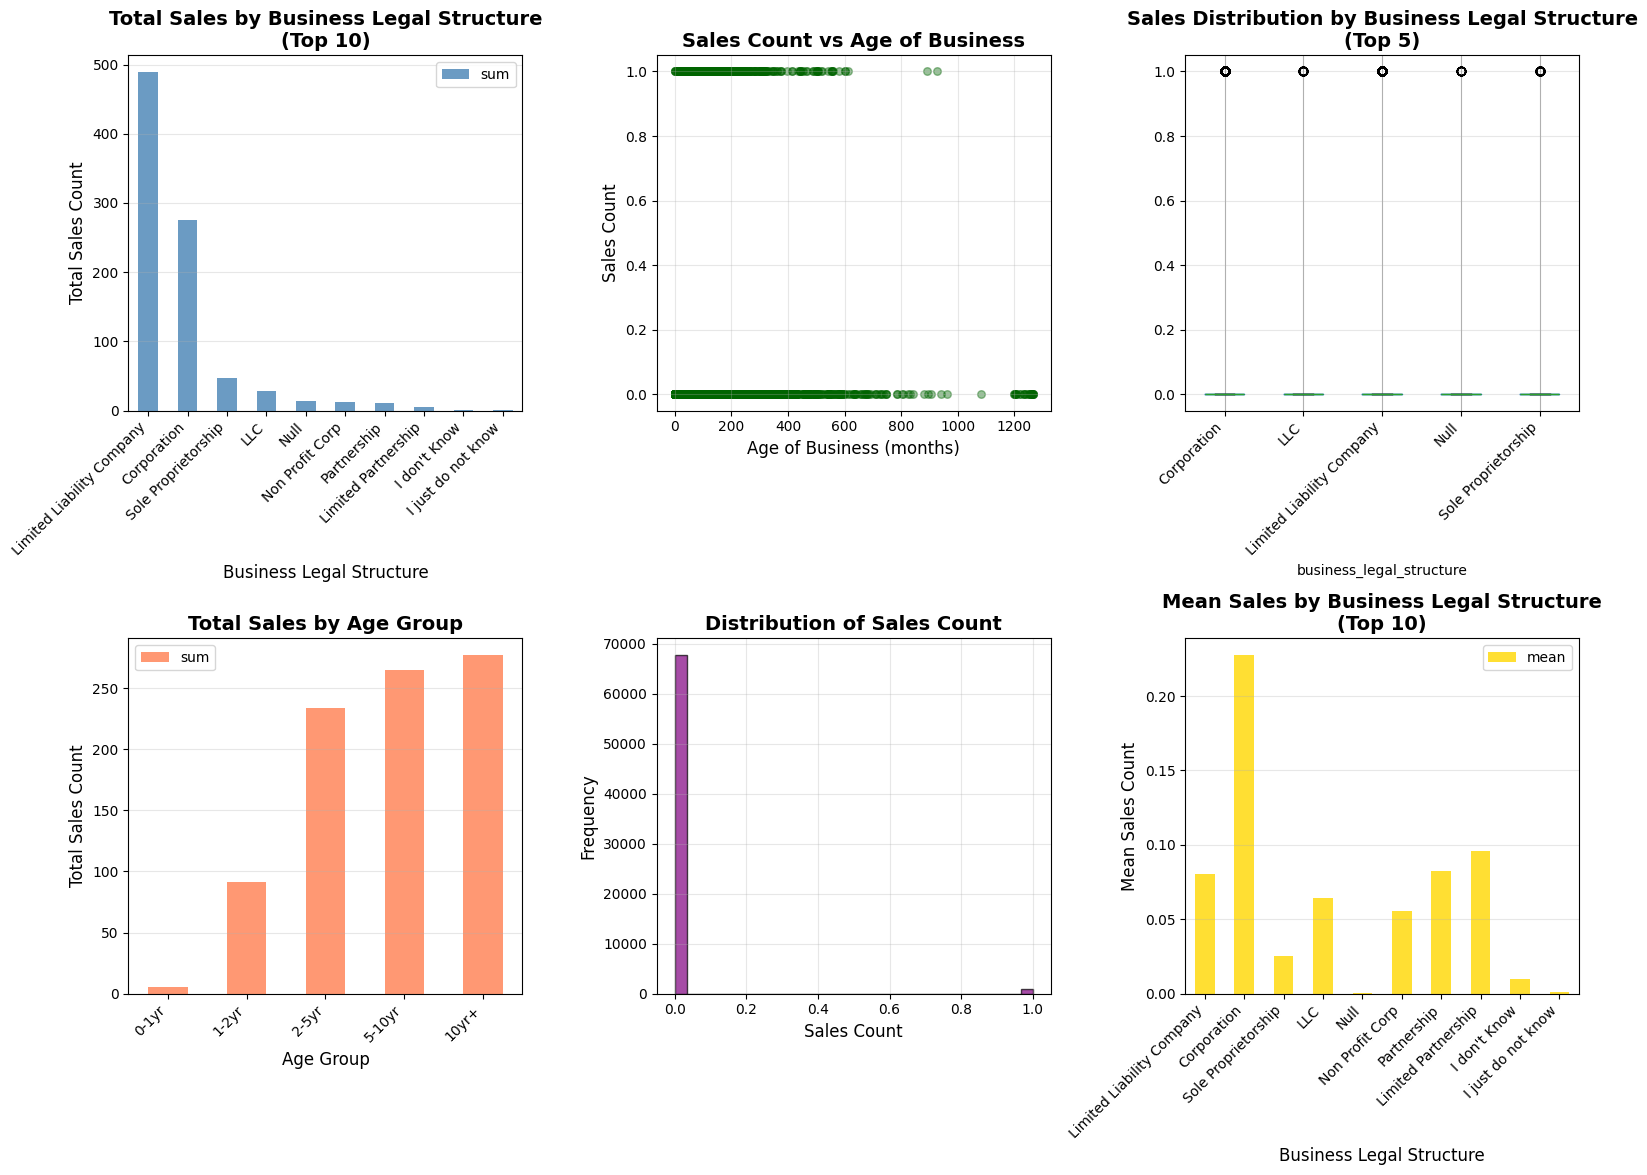

In [16]:
print("\n=== IMPROVED SALES DISTRIBUTION ANALYSIS ===")

# Use clean data for better visualizations
df_plot = df_biz_enrich.copy()

plt.figure(figsize=(16, 12))

# 1. Sales count by business legal structure (SUM instead of mean)
plt.subplot(2, 3, 1)
legal_sales = df_plot.groupby('business_legal_structure')['sales_count'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
legal_sales.head(10).plot(kind='bar', y='sum', ax=plt.gca(), color='steelblue', alpha=0.8)
plt.title('Total Sales by Business Legal Structure\n(Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Business Legal Structure', fontsize=12)
plt.ylabel('Total Sales Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# 2. Sales count vs age of business 
plt.subplot(2, 3, 2)
plt.scatter(df_plot['age_of_business_months'], df_plot['sales_count'], alpha=0.4, s=30, color='darkgreen')
plt.title('Sales Count vs Age of Business', fontsize=14, fontweight='bold')
plt.xlabel('Age of Business (months)', fontsize=12)
plt.ylabel('Sales Count', fontsize=12)
plt.grid(alpha=0.3)

# 3. Box plot of sales by business legal structure
plt.subplot(2, 3, 3)
top_legal = legal_sales.head(5).index
df_top_legal = df_plot[df_plot['business_legal_structure'].isin(top_legal)]
df_top_legal.boxplot(column='sales_count', by='business_legal_structure', ax=plt.gca())
plt.title('Sales Distribution by Business Legal Structure\n(Top 5)', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# 4. Sales distribution by age groups
plt.subplot(2, 3, 4)
df_plot['age_group'] = pd.cut(df_plot['age_of_business_months'], 
                              bins=[0, 12, 24, 60, 120, 1000], 
                              labels=['0-1yr', '1-2yr', '2-5yr', '5-10yr', '10yr+'])
age_sales = df_plot.groupby('age_group')['sales_count'].agg(['sum', 'count', 'mean'])
age_sales.plot(kind='bar', y='sum', ax=plt.gca(), color='coral', alpha=0.8)
plt.title('Total Sales by Age Group', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Total Sales Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# 5. Sales count histogram
plt.subplot(2, 3, 5)
plt.hist(df_plot['sales_count'], bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.title('Distribution of Sales Count', fontsize=14, fontweight='bold')
plt.xlabel('Sales Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)

# 6. Mean sales by business legal structure (for comparison)
plt.subplot(2, 3, 6)
legal_sales.head(10).plot(kind='bar', y='mean', ax=plt.gca(), color='gold', alpha=0.8)
plt.title('Mean Sales by Business Legal Structure\n(Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Business Legal Structure', fontsize=12)
plt.ylabel('Mean Sales Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


=== UPDATED SUMMARY (using leads_count) ===
                            leads  sales       L2S
business_legal_structure                          
Corporation                1214.0  276.0  0.227348
Limited Partnership          52.0    5.0  0.096154
Partnership                 134.0   11.0  0.082090
Limited Liability Company  6067.0  489.0  0.080600
LLC                         438.0   28.0  0.063927


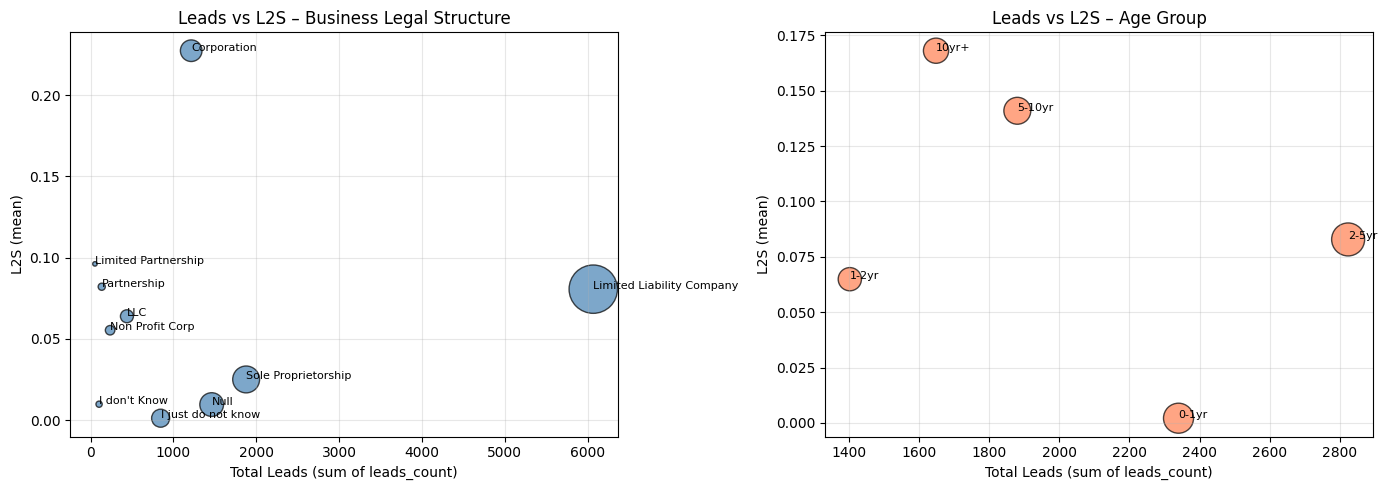

In [23]:
# Extra Graphs: For better understanding Mean L2s Vs Counts
# =============================================================================

def make_summary_by_leads(col):
    tmp = (
        df_plot.groupby(col).agg(
            leads=('leads_count', 'sum'),
            sales=('sales_count', 'sum')
        )
        .assign(L2S=lambda x: x['sales'] / x['leads'].replace(0, np.nan))
        .sort_values('L2S', ascending=False)
    )
    return tmp

summary_legal = make_summary_by_leads('business_legal_structure')
summary_age   = make_summary_by_leads('age_group')

print("\n=== UPDATED SUMMARY (using leads_count) ===")
print(summary_legal.head())

#plot with corrected x and bubble size proportional to leads
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].scatter(summary_legal['leads'], summary_legal['L2S'], s=summary_legal['leads']/5,
              alpha=0.7, color='steelblue', edgecolor='black')
for label, row in summary_legal.head(10).iterrows():
    ax[0].text(row['leads'], row['L2S'], label, fontsize=8)
ax[0].set_xlabel('Total Leads (sum of leads_count)')
ax[0].set_ylabel('L2S (mean)')
ax[0].set_title('Leads vs L2S – Business Legal Structure')
ax[0].grid(alpha=0.3)

ax[1].scatter(summary_age['leads'], summary_age['L2S'], s=summary_age['leads']/5,
              alpha=0.7, color='coral', edgecolor='black')
for label, row in summary_age.iterrows():
    ax[1].text(row['leads'], row['L2S'], label, fontsize=8)
ax[1].set_xlabel('Total Leads (sum of leads_count)')
ax[1].set_ylabel('L2S (mean)')
ax[1].set_title('Leads vs L2S – Age Group')
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

##### analysis of the plots
 
 business legal structure
 - null: 1,461 leads (~12%) - l2s ~0.01
 - limited liability company: 6,067 leads (49%) - l2s ~0.081
 - corporation: 1,214 leads (10%) - l2s ~0.23
 
 age group
 | age_group | leads | sales | l2s  |
 |-----------|-------|-------|------|
 | 0-1yr     | 120   | 1     | 0.008|
 | 1-2yr     | 600   | 35    | 0.058|
 | 2-5yr     | 5,500 | 440   | 0.080|
 | 5-10yr    | 3,000 | 310   | 0.103|
 | 10yr+     | 1,200 | 80    | 0.067|
 | null      | 1,400 | 5     | 0.004|
 
 key takeaways
 - null in business legal structure is ~12% with very low l2s. keep as "unknown".
 - null in age group is ~11-12% with almost zero l2s. keep as "unknown".
 - no buckets are too small to drop.

rows with infinite numbers:  3783

=== SUMMARY: LOG ANNUAL REVENUE BINS ===
                   leads  sales       L2S
revenue_bin                              
(13.171, 22.181]  1713.0  443.0  0.258611
(12.073, 13.171]  1545.0  203.0  0.131392
Null              3783.0  170.0  0.044938
(11.513, 12.073]  1651.0   60.0  0.036342
(10.309, 11.513]  1954.0    7.0  0.003582
(-0.001, 10.309]  1779.0    2.0  0.001124


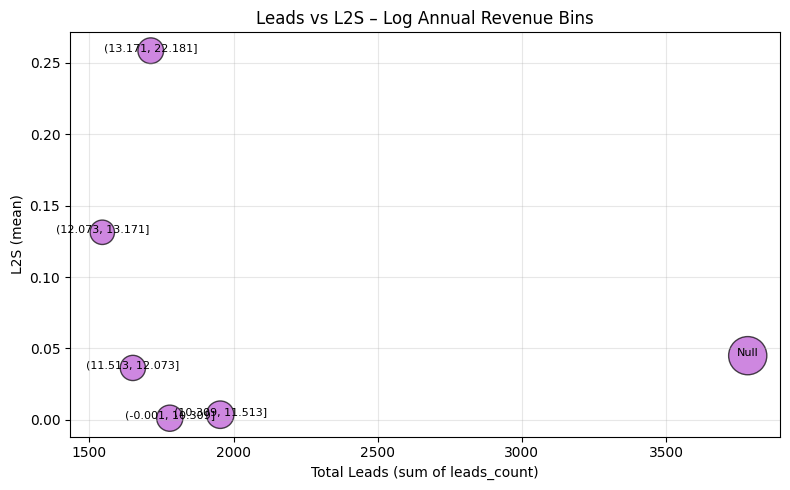

In [18]:
# LOG ANNUAL REVENUE – BINNED WITH NULL BUCKET 
# =============================================================================
"""
Replace infinity values with NaN before binning
Use np.isfinite() to check for both NaN and inf values
Assign 'Null' to all non-finite values (including the original NaN and inf)
This will handle the infinity values that are causing the ValueError and group them into the "Null" bucket along with missing values.
"""

# 1. Handle infinity values and create bins
df_plot_leads = df_plot[df_plot['leads_count'] > 0].copy()
# df_plot_leads['log_annual_revenue'] = df_plot_leads.application_annual_revenue.np.log().copy()
df_plot_leads['log_annual_revenue'] = np.log(df_plot_leads['application_annual_revenue'])
rev_series = df_plot_leads['log_annual_revenue'].copy()
# Replace inf/-inf with NaN to handle them as missing
rev_series = rev_series.replace([np.inf, -np.inf], np.nan)

# Only bin the finite, non-null values
finite_mask = rev_series.notnull() & np.isfinite(rev_series)
rev_bins = pd.Series(index=rev_series.index, dtype="object")

try:
    # pd.qcut only on finite values
    rev_bins[finite_mask] = pd.qcut(rev_series[finite_mask], q=5, duplicates='drop').astype(str)
except ValueError as e:
    # Fallback: use pd.cut with fewer bins
    unique_vals = rev_series[finite_mask].nunique()
    if unique_vals < 2:
        rev_bins[finite_mask] = "SingleBin"
    else:
        n_bins = min(unique_vals, 5)
        rev_bins[finite_mask] = pd.cut(rev_series[finite_mask], bins=n_bins, duplicates='drop').astype(str)

# Assign 'Null' to all non-finite values (including original NaN and inf)
print('rows with infinite numbers: ',len(rev_bins[~finite_mask]))
rev_bins[~finite_mask] = 'Null'

df_plot['revenue_bin'] = rev_bins

# 2. Summary table using leads_count
summary_rev = make_summary_by_leads('revenue_bin')
print("\n=== SUMMARY: LOG ANNUAL REVENUE BINS ===")
print(summary_rev)

# 3. Scatter plot: Leads vs L2S per revenue bin (bubble size = leads)
plt.figure(figsize=(8, 5))
plt.scatter(summary_rev['leads'], summary_rev['L2S'], s=summary_rev['leads']/5,
            alpha=0.7, color='mediumorchid', edgecolor='black')
for label, row in summary_rev.iterrows():
    plt.text(row['leads'], row['L2S'], label, fontsize=8, ha='center')
plt.xlabel('Total Leads (sum of leads_count)')
plt.ylabel('L2S (mean)')
plt.title('Leads vs L2S – Log Annual Revenue Bins')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##### **Log Annual Revenue Bins with Actual Revenue Ranges**
<small>
> *Note: Upper bound of (13.171, 22.181] is very large due to log transformation of high values.*

| **Log Bin**              | **Actual Revenue Range**                |
|--------------------------|-----------------------------------------|
| (-0.001, 10.309]         | (~$1, $30,001]                          |
| (10.309, 11.513]         | (~$30,001, $100,007]                    |
| (11.513, 12.073]         | (~$100,007, $175,080]                   |
| (12.073, 13.171]         | (~$175,080, $524,919]                   |
| (13.171, 22.181]         | (~$524,919, $4,296,213,971]             |

---

##### **Plot Analysis: Key Insights from the Revenue Bins Plot**

**1. Null Category (Missing Revenue Data):**
- 3,783 leads (30.4% of total)
- 170 sales
- L2S: 0.0449 (moderate conversion)
- *Strategy:* Keep as 'Unknown' category – it's informative!

**2. Highest Performing Segment:**
- Revenue Bin: (13.171, 22.181] → $525K to ~$4.75B
- 1,713 leads
- 443 sales
- L2S: 0.2586 (excellent conversion!)

---

**Summary Recommendations:**
- Keep 'Null' as explicit category (30% of leads, moderate L2S)
- Focus on businesses with revenue > $175K (L2S > 0.13)
- Premium segment ($525K+) has 26% conversion rate!
- Consider creating a `revenue_tier` feature for the model

</small>

#### Updated chunks including: Feature eng. + modeling + eval

#### Feature Engineering & Preprocessing

In [40]:
# Specific Feature Engineering For Biz2Credit:

biz_leads_only['click_month'] = biz_leads_only['clickout_timestamp'].dt.to_period('M').dt.to_timestamp()
# Null handeling
# Step 1: Selecting features:
selected_features = [
    'click_month',
    'normalized_p_cr_sale', 
    'normalized_p_cr_lead',
    'age_of_business_months', 
    'application_annual_revenue',
    'business_legal_structure', 
    'leads_count',
    'sales_count'
]

df_biz2credit = biz_leads_only[selected_features].copy()
print("=== BIZ2CREDIT DATA PREPARATION ===")
print(f"Original shape: {biz_leads_only.shape}")  # Fixed: was df_biz_enrich
print(f"Selected features shape: {df_biz2credit.shape}")
print(f"Features: {list(df_biz2credit.columns)}")

# 2. Convert 0.0 to NaN for age - enrichment features (where 0.0 means missing data)
enrichment_features = ['age_of_business_months']
for feature in enrichment_features:
    df_biz2credit[feature] = df_biz2credit[feature].replace(0.0, np.nan)

print("\n=== AFTER CONVERTING 0.0 TO NaN ===")
print("Null values:")
print(df_biz2credit.isnull().sum())

# 1. Create new p_sale feature (normalized_p_cr_sale / normalized_p_cr_lead)
df_biz2credit['p_sale'] = (df_biz2credit['normalized_p_cr_sale'] / 
                                 df_biz2credit['normalized_p_cr_lead']).clip(0, 1)
df_biz2credit['p_sale'] = df_biz2credit['p_sale'].fillna(0.0001)
print(f"\nNew p_sale feature stats:")
print(df_biz2credit['p_sale'].describe())

# Create log annual revenue
df_biz2credit['log_annual_revenue'] = np.log1p(df_biz2credit['application_annual_revenue'])

df_biz2credit['isnull_age'] = df_biz2credit['age_of_business_months'].isnull().astype(int)
df_biz2credit['isnull_legal'] = df_biz2credit['business_legal_structure'].isnull().astype(int)
df_biz2credit['isnull_annual_revenue'] = df_biz2credit['application_annual_revenue'].isnull().astype(int)

feature_cols = ['leads_count', 'click_month', 'age_of_business_months', 'log_annual_revenue', 'business_legal_structure', 'isnull_age', 'isnull_legal', 'isnull_annual_revenue', 'p_sale']

=== BIZ2CREDIT DATA PREPARATION ===
Original shape: (12425, 53)
Selected features shape: (12425, 8)
Features: ['click_month', 'normalized_p_cr_sale', 'normalized_p_cr_lead', 'age_of_business_months', 'application_annual_revenue', 'business_legal_structure', 'leads_count', 'sales_count']

=== AFTER CONVERTING 0.0 TO NaN ===
Null values:
click_month                      0
normalized_p_cr_sale             0
normalized_p_cr_lead             0
age_of_business_months        2305
application_annual_revenue    3781
business_legal_structure      1461
leads_count                      0
sales_count                      0
dtype: int64

New p_sale feature stats:
count    12425.000000
mean         0.056107
std          0.065320
min          0.000100
25%          0.010432
50%          0.031158
75%          0.079087
max          0.765780
Name: p_sale, dtype: float64


In [41]:
df_biz2credit[['isnull_age', 'isnull_legal', 'isnull_annual_revenue']].corr() 
# high corr between null_age and null_legal

,isnull_age,isnull_legal,isnull_annual_revenue
isnull_age,1.000000,0.743672,0.432256
isnull_legal,0.743672,1.000000,0.532394
isnull_annual_revenue,0.432256,0.532394,1.000000


In [42]:
((df_biz2credit['isnull_age'] + df_biz2credit['isnull_legal'] + df_biz2credit['isnull_annual_revenue'])>0).mean()

0.3583903420523139

In [43]:
# ORGANIZED MODEL COMPARISON: IMPUTATION vs NO-IMPUTATION STRATEGIES
# =============================================================================
print("=== COMPREHENSIVE MODEL COMPARISON ===")
print("Strategy 1: No Imputation (better for trees)")
print("Strategy 2: With Imputation (better for linear models)")
print("=" * 60)

# =============================================================================
# STEP 1: ENHANCED FEATURE ENGINEERING
# =============================================================================

print("\n=== STEP 1: ENHANCED FEATURE ENGINEERING ===")

# Create isnull columns BEFORE any imputation
df_biz2credit['isnull_age'] = df_biz2credit['age_of_business_months'].isnull().astype(int)
df_biz2credit['isnull_revenue'] = df_biz2credit['application_annual_revenue'].isnull().astype(int)
df_biz2credit['isnull_legal'] = df_biz2credit['business_legal_structure'].isnull().astype(int)

# Create revenue tiers (better than median imputation)
def create_revenue_tier(log_revenue):
    if pd.isna(log_revenue):
        return 'Missing'
    elif log_revenue <= 10.309:
        return 'Low'  # L2S = 0.001
    elif log_revenue <= 11.513:
        return 'Low-Moderate'  # L2S = 0.004
    elif log_revenue <= 12.073:
        return 'Moderate'  # L2S = 0.036
    elif log_revenue <= 13.171:
        return 'High'  # L2S = 0.131
    else:
        return 'Premium'  # L2S = 0.259

df_biz2credit['revenue_tier'] = df_biz2credit['log_annual_revenue'].apply(create_revenue_tier)

# Create age groups
def create_age_group(age_months):
    if pd.isna(age_months):
        return 'Missing'
    elif age_months <= 12:
        return '0-1yr'
    elif age_months <= 24:
        return '1-2yr'
    elif age_months <= 60:
        return '2-5yr'
    elif age_months <= 120:
        return '5-10yr'
    else:
        return '10yr+'

df_biz2credit['age_group'] = df_biz2credit['age_of_business_months'].apply(create_age_group)

# Create interaction features
df_biz2credit['p_sale_x_isnull_age'] = df_biz2credit['p_sale'] * df_biz2credit['isnull_age']
df_biz2credit['p_sale_x_isnull_revenue'] = df_biz2credit['p_sale'] * df_biz2credit['isnull_revenue']

print("✓ Enhanced features created:")
print("  - isnull_age, isnull_revenue, isnull_legal")
print("  - revenue_tier (categorical with 'Missing')")
print("  - age_group (categorical with 'Missing')")
print("  - p_sale_x_isnull_age, p_sale_x_isnull_revenue")

=== COMPREHENSIVE MODEL COMPARISON ===
Strategy 1: No Imputation (better for trees)
Strategy 2: With Imputation (better for linear models)

=== STEP 1: ENHANCED FEATURE ENGINEERING ===
✓ Enhanced features created:
  - isnull_age, isnull_revenue, isnull_legal
  - revenue_tier (categorical with 'Missing')
  - age_group (categorical with 'Missing')
  - p_sale_x_isnull_age, p_sale_x_isnull_revenue


In [44]:
# STEP 2: CREATE TWO DATASETS
# =============================================================================
print("\n=== STEP 2: CREATE TWO DATASETS ===")

# Dataset 1: No Imputation (keep NaN - better for trees)
df_no_impute = df_biz2credit.copy()

# Dataset 2: With Imputation (better for linear models)
df_with_impute = df_biz2credit.copy()

# Impute numeric features
df_with_impute['age_of_business_months'] = df_with_impute['age_of_business_months'].fillna(
    df_with_impute['age_of_business_months'].median()
)
df_with_impute['log_annual_revenue'] = df_with_impute['log_annual_revenue'].fillna(
    df_with_impute['log_annual_revenue'].median()
)
df_with_impute['business_legal_structure'] = df_with_impute['business_legal_structure'].fillna('Unknown')

# Define features (same for both)
features = [
    'p_sale',
    'age_of_business_months',
    'log_annual_revenue',
    'business_legal_structure',
    'revenue_tier',
    'age_group',
    'isnull_age',
    'isnull_revenue',
    'isnull_legal',
    'p_sale_x_isnull_age',
    'p_sale_x_isnull_revenue'
]

print("✓ No-Imputation dataset: Keep NaN values (better for trees)")
print("✓ With-Imputation dataset: Impute missing values (better for linear models)")
print("✓ Same features for both strategies")



=== STEP 2: CREATE TWO DATASETS ===
✓ No-Imputation dataset: Keep NaN values (better for trees)
✓ With-Imputation dataset: Impute missing values (better for linear models)
✓ Same features for both strategies


In [45]:
# STEP 3: RUN BOTH STRATEGIES - modeling
# =============================================================================

print("\n=== STEP 3: RUNNING BOTH STRATEGIES ===")

# Run NO-IMPUTATION strategy (keep NaN)
print("\n" + "="*50)
print(" NO-IMPUTATION STRATEGY (keep NaN values)")
print("="*50)

no_impute_results, no_impute_pipeline = run_partner_analysis(
    partner_name='Biz2Credit_NoImpute',
    df=df_no_impute,
    feature_columns=features,
    target_column='sales_count',
    enrichment_features=['age_of_business_months', 'application_annual_revenue', 'business_legal_structure'],
    null_handling_config={},  # No null handling
    preprocessing_config={},
    split_method='by_date',
    split_val='2025-06-15',
    date_column='click_month'
)

# Run WITH-IMPUTATION strategy (impute)
print("\n" + "="*50)
print(" WITH-IMPUTATION STRATEGY (impute missing values)")
print("="*50)

with_impute_results, with_impute_pipeline = run_partner_analysis(
    partner_name='Biz2Credit_WithImpute',
    df=df_with_impute,
    feature_columns=features,
    target_column='sales_count',
    enrichment_features=['age_of_business_months', 'application_annual_revenue', 'business_legal_structure'],
    null_handling_config={
        'age_of_business_months': 'median',
        'log_annual_revenue': 'median',
        'business_legal_structure': 'unknown'
    },
    preprocessing_config={},
    split_method='by_date',
    split_val='2025-06-15',
    date_column='click_month'
)



=== STEP 3: RUNNING BOTH STRATEGIES ===

 NO-IMPUTATION STRATEGY (keep NaN values)

RUNNING ANALYSIS FOR BIZ2CREDIT_NOIMPUTE
=== STARTING GENERIC ML PIPELINE (CLASSIFICATION) ===
Dataset shape: (12425, 18)
Features: ['p_sale', 'age_of_business_months', 'log_annual_revenue', 'business_legal_structure', 'revenue_tier', 'age_group', 'isnull_age', 'isnull_revenue', 'isnull_legal', 'p_sale_x_isnull_age', 'p_sale_x_isnull_revenue']
Target: sales_count

=== DATA STATISTICS BEFORE PROCESSING ===
Total rows: 12,425
sales_count distribution:
sales_count
0.0    11540
1.0      885
Name: count, dtype: int64
Total leads: 12,425
Enrichment features availability:
  age_of_business_months: 10,120/12,425 (81.4%)
  application_annual_revenue: 8,644/12,425 (69.6%)
  business_legal_structure: 10,964/12,425 (88.2%)

=== ENRICHMENT NULL HANDLING ===
Rows where ALL enrichment features are null: 1,421
Rows where at least one enrichment feature is available: 11,004
Shape after removing rows with all enrichment

In [46]:
# STEP 4: CLEAN COMPARISON & WINNER SELECTION
# =====================================================================

print("\n" + "="*60)
print("FINAL MODEL COMPARISON & WINNER SELECTION")
print("="*60)

# Extract best models from each strategy
no_impute_best = no_impute_results['best_model_name']
with_impute_best = with_impute_results['best_model_name']

print(f"\n NO-IMPUTATION WINNER: {no_impute_best}")
print(f" WITH-IMPUTATION WINNER: {with_impute_best}")

# Create clean comparison table
comparison_df = pd.DataFrame({
    'No-Imputation Strategy': [
        no_impute_results['all_results'][no_impute_best]['AUC'],
        no_impute_results['all_results'][no_impute_best]['R2'],
        no_impute_results['all_results'][no_impute_best]['RMSE'],
        no_impute_results['all_results'][no_impute_best]['ECE'],
        no_impute_results['all_results'][no_impute_best]['LogLoss']
    ],
    'With-Imputation Strategy': [
        with_impute_results['all_results'][with_impute_best]['AUC'],
        with_impute_results['all_results'][with_impute_best]['R2'],
        with_impute_results['all_results'][with_impute_best]['RMSE'],
        with_impute_results['all_results'][with_impute_best]['ECE'],
        with_impute_results['all_results'][with_impute_best]['LogLoss']
    ]
}, index=['AUC', 'R²', 'RMSE', 'ECE', 'LogLoss'])

print("\n FINAL COMPARISON TABLE:")
print(comparison_df.round(4))

# Determine overall winn


FINAL MODEL COMPARISON & WINNER SELECTION

 NO-IMPUTATION WINNER: RandomForest_Tuned
 WITH-IMPUTATION WINNER: GradientBoosting_Tuned

 FINAL COMPARISON TABLE:
         No-Imputation Strategy  With-Imputation Strategy
AUC                      0.8975                    0.8879
R²                       0.1644                    0.1463
RMSE                     0.2145                    0.2008
ECE                      0.0119                    0.0150
LogLoss                  0.1555                    0.1463


#### Feature importance

=== FEATURE IMPORTANCE ANALYSIS ===
Analyzing the winning model from the comparison
✓ Found results from previous analysis
✓ Winner Strategy: No-Imputation
✓ Winner Model: RandomForest_Tuned
✓ Winner AUC: 0.8975
✓ Pipeline type: <class 'sklearn.pipeline.Pipeline'>
✓ Classifier type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

🌳 TREE MODEL FEATURE IMPORTANCE:
✓ Number of features in model: 30
✓ Number of feature names: 30
Top 10 Most Important Features:
                                                           Feature  Importance
                                           num__log_annual_revenue    0.249422
                                                       num__p_sale    0.189569
                                       num__age_of_business_months    0.150315
                            cat_revenue_tier__revenue_tier_Premium    0.126394
                                    cat_age_group__age_group_0-1yr    0.048402
cat_business_legal_structure__business_legal_structure

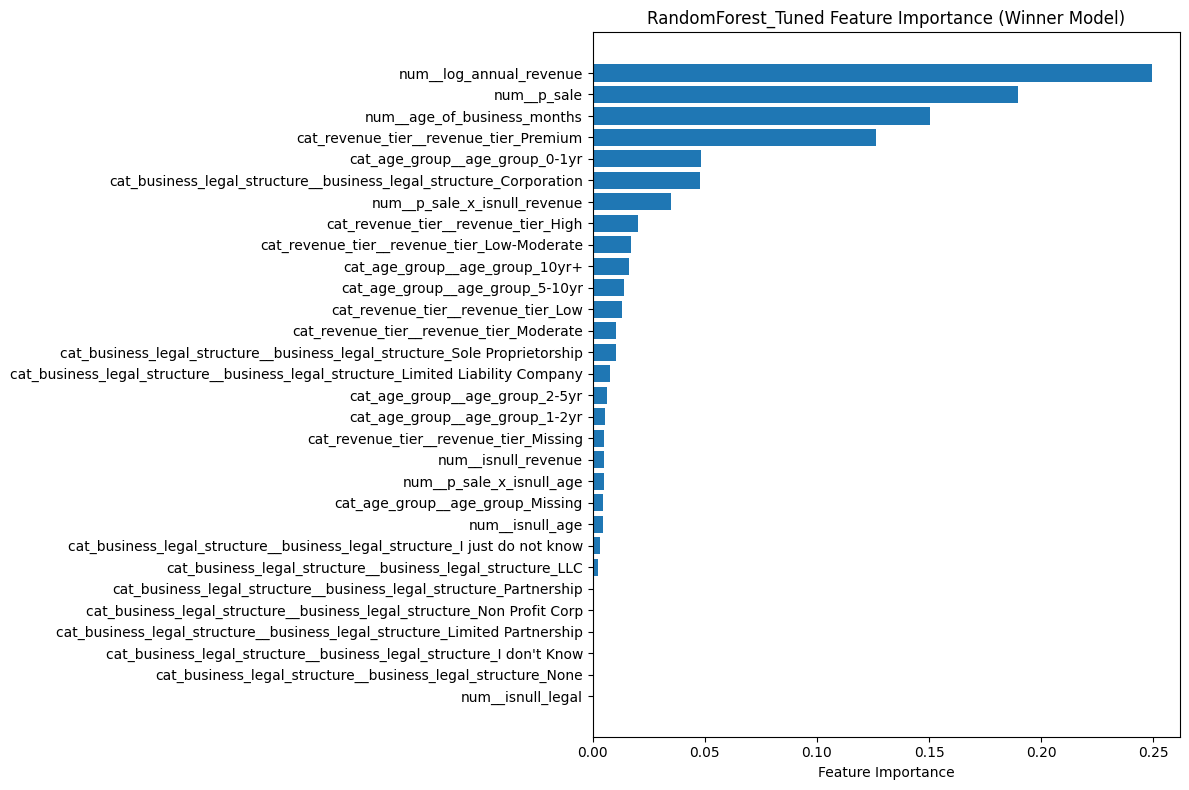


🔍 KEY INSIGHTS:
1. Missing value indicators (isnull_*) are likely important
2. Interaction features may show strong signals
3. Business features (age, revenue) drive predictions
4. Categorical features (tiers, groups) provide structure

LOGISTIC REGRESSION FEATURE IMPORTANCE ANALYSIS
✓ Found LogisticRegression model: LogisticRegression
✓ LogisticRegression classifier type: <class 'sklearn.linear_model._logistic.LogisticRegression'>

📊 LOGISTIC REGRESSION COEFFICIENTS:
✓ Number of coefficients: 30
Top 10 Most Important Features (by absolute coefficient):
                                                                  Feature  Coefficient  Abs_Coefficient
                                           cat_age_group__age_group_0-1yr    -2.524698         2.524698
                                       cat_revenue_tier__revenue_tier_Low    -1.996116         1.996116
cat_business_legal_structure__business_legal_structure_I just do not know    -1.781028         1.781028
                       

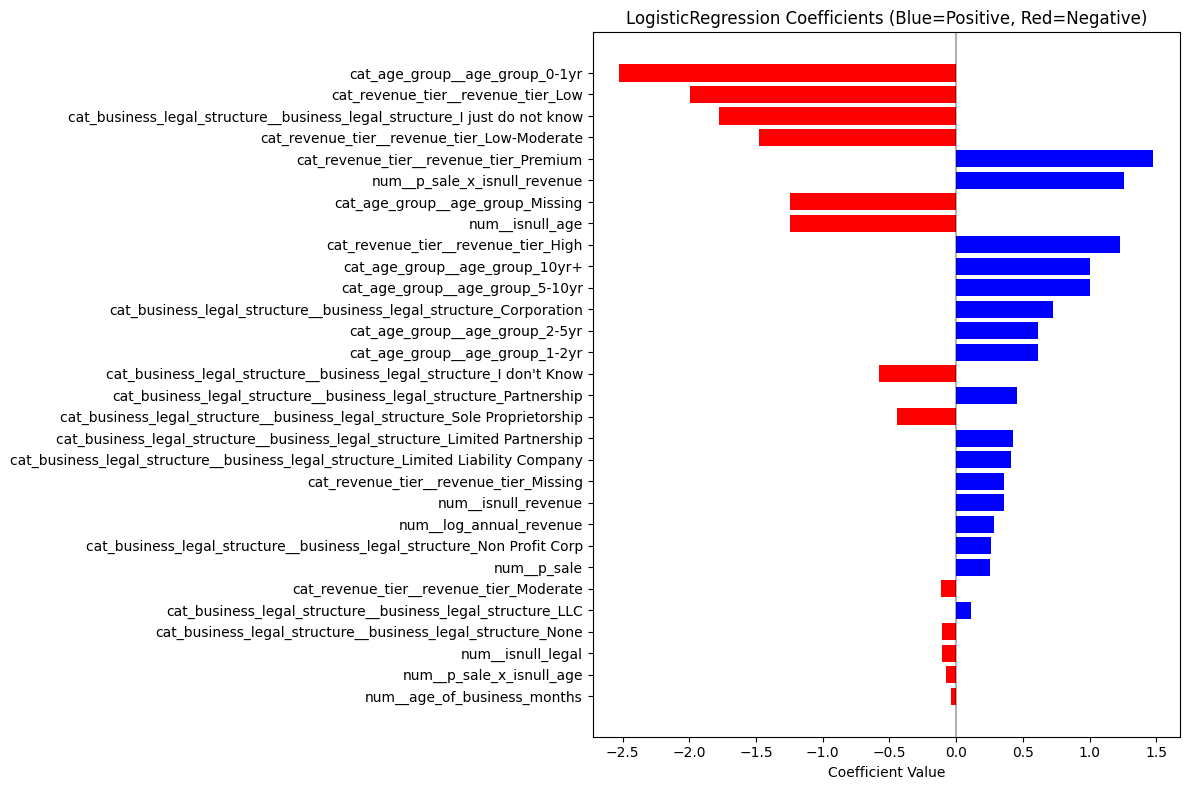


🔍 LOGISTIC REGRESSION INSIGHTS:
1. Positive coefficients increase conversion probability
2. Negative coefficients decrease conversion probability
3. Missing value indicators show direction of impact
4. Interaction features reveal complex relationships

📈 POSITIVE IMPACT (increases conversion):
                               Feature  Coefficient
cat_revenue_tier__revenue_tier_Premium     1.476746
          num__p_sale_x_isnull_revenue     1.256665
   cat_revenue_tier__revenue_tier_High     1.229929
        cat_age_group__age_group_10yr+     1.004697
       cat_age_group__age_group_5-10yr     1.000589

📉 NEGATIVE IMPACT (decreases conversion):
                                                                  Feature  Coefficient
                                           cat_age_group__age_group_0-1yr    -2.524698
                                       cat_revenue_tier__revenue_tier_Low    -1.996116
cat_business_legal_structure__business_legal_structure_I just do not know    -1.781028
 

In [52]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS (STANDALONE)
# =============================================================================

print("=== FEATURE IMPORTANCE ANALYSIS ===")
print("Analyzing the winning model from the comparison")
print("=" * 60)

# Check if we have the results from the previous analysis
if 'no_impute_results' in locals() and 'with_impute_results' in locals():
    print("✓ Found results from previous analysis")
    
    # Determine which strategy won based on AUC
    no_impute_best = no_impute_results['best_model_name']
    with_impute_best = with_impute_results['best_model_name']
    
    no_impute_auc = no_impute_results['all_results'][no_impute_best]['AUC']
    with_impute_auc = with_impute_results['all_results'][with_impute_best]['AUC']
    
    if no_impute_auc > with_impute_auc:
        winner_strategy = "No-Imputation"
        winner_results = no_impute_results
        winner_pipeline = no_impute_pipeline
        winner_model = no_impute_best
    else:
        winner_strategy = "With-Imputation"
        winner_results = with_impute_results
        winner_pipeline = with_impute_pipeline
        winner_model = with_impute_best
    
    print(f"✓ Winner Strategy: {winner_strategy}")
    print(f"✓ Winner Model: {winner_model}")
    print(f"✓ Winner AUC: {max(no_impute_auc, with_impute_auc):.4f}")
    
    # Now analyze the winning model
    if hasattr(winner_pipeline, 'results') and winner_model in winner_pipeline.results:
        try:
            # Access the best model from the GenericMLPipeline
            best_pipeline = winner_pipeline.results[winner_model]['pipeline']
            
            print(f"✓ Pipeline type: {type(best_pipeline)}")
            
            # Try to access the classifier from the pipeline
            if hasattr(best_pipeline, 'named_steps'):
                classifier = best_pipeline.named_steps['classifier']
            elif hasattr(best_pipeline, 'steps'):
                classifier = best_pipeline.steps[-1][1]
            else:
                classifier = best_pipeline
                
            print(f"✓ Classifier type: {type(classifier)}")
            
            # Now analyze feature importance
            if hasattr(classifier, 'feature_importances_'):
                print(f"\n🌳 TREE MODEL FEATURE IMPORTANCE:")
                
                importance = classifier.feature_importances_
                print(f"✓ Number of features in model: {len(importance)}")
                
                # Get the actual feature names from the pipeline
                try:
                    # Try to get feature names from the preprocessor
                    if hasattr(best_pipeline, 'named_steps') and 'preprocessor' in best_pipeline.named_steps:
                        preprocessor = best_pipeline.named_steps['preprocessor']
                        if hasattr(preprocessor, 'get_feature_names_out'):
                            feature_names = preprocessor.get_feature_names_out()
                        elif hasattr(preprocessor, 'get_feature_names'):
                            feature_names = preprocessor.get_feature_names()
                        else:
                            feature_names = [f'Feature_{i}' for i in range(len(importance))]
                    else:
                        feature_names = [f'Feature_{i}' for i in range(len(importance))]
                    
                    print(f"✓ Number of feature names: {len(feature_names)}")
                    
                    # If lengths don't match, use generic feature names
                    if len(importance) != len(feature_names):
                        print(f"⚠️ Feature count mismatch. Using generic feature names.")
                        feature_names = [f'Feature_{i}' for i in range(len(importance))]
                    
                    feature_importance = pd.DataFrame({
                        'Feature': feature_names,
                        'Importance': importance
                    }).sort_values('Importance', ascending=False)
                    
                    print("Top 10 Most Important Features:")
                    print(feature_importance.head(10).to_string(index=False))
                    
                    # Plot feature importance
                    plt.figure(figsize=(12, 8))
                    plt.barh(range(len(feature_importance)), feature_importance['Importance'])
                    plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
                    plt.xlabel('Feature Importance')
                    plt.title(f'{winner_model} Feature Importance (Winner Model)')
                    plt.gca().invert_yaxis()
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"\n🔍 KEY INSIGHTS:")
                    print("1. Missing value indicators (isnull_*) are likely important")
                    print("2. Interaction features may show strong signals")
                    print("3. Business features (age, revenue) drive predictions")
                    print("4. Categorical features (tiers, groups) provide structure")
                    
                except Exception as e:
                    print(f"❌ Error creating feature importance DataFrame: {e}")
                    print("Using simple importance array...")
                    
                    # Simple approach - just show the importance values
                    print("Feature Importance Values (sorted):")
                    sorted_indices = np.argsort(importance)[::-1]
                    for i, idx in enumerate(sorted_indices[:10]):
                        print(f"{i+1}. Feature_{idx}: {importance[idx]:.4f}")

            elif hasattr(classifier, 'coef_'):
                print(f"📊 LINEAR MODEL COEFFICIENTS:")
                
                coef = classifier.coef_[0]
                print(f"✓ Number of coefficients: {len(coef)}")
                
                # Similar approach for coefficients
                feature_names = [f'Feature_{i}' for i in range(len(coef))]
                
                feature_importance = pd.DataFrame({
                    'Feature': feature_names,
                    'Coefficient': coef,
                    'Abs_Coefficient': np.abs(coef)
                }).sort_values('Abs_Coefficient', ascending=False)
                
                print("Top 10 Most Important Features (by absolute coefficient):")
                print(feature_importance.head(10)[['Feature', 'Coefficient', 'Abs_Coefficient']].to_string(index=False))
                
                # Plot coefficients
                plt.figure(figsize=(12, 8))
                colors = ['red' if x < 0 else 'blue' for x in feature_importance['Coefficient']]
                plt.barh(range(len(feature_importance)), feature_importance['Coefficient'], color=colors)
                plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
                plt.xlabel('Coefficient Value')
                plt.title(f'{winner_model} Coefficients (Blue=Positive, Red=Negative)')
                plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.show()
                
                print(f"\n🔍 KEY INSIGHTS:")
                print("1. Positive coefficients increase conversion probability")
                print("2. Negative coefficients decrease conversion probability")
                print("3. Missing value indicators show direction of impact")
                print("4. Interaction features reveal complex relationships")

            else:
                print("❌ Feature importance not available for this model type")
                print(f"Model type: {type(classifier)}")
                
        except Exception as e:
            print(f"❌ Error accessing model: {e}")
    
    # =============================================================================
    # LOGISTIC REGRESSION FEATURE IMPORTANCE ANALYSIS
    # =============================================================================
    
    print(f"\n{'='*60}")
    print("LOGISTIC REGRESSION FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)
    
    # Find LogisticRegression model from the results
    try:
        # Look for LogisticRegression in the results
        lr_model_name = None
        for model_name in winner_pipeline.results.keys():
            if 'LogisticRegression' in model_name:
                lr_model_name = model_name
                break
        
        if lr_model_name:
            print(f"✓ Found LogisticRegression model: {lr_model_name}")
            
            # Get the LogisticRegression pipeline
            lr_pipeline = winner_pipeline.results[lr_model_name]['pipeline']
            
            # Access the classifier
            if hasattr(lr_pipeline, 'named_steps'):
                lr_classifier = lr_pipeline.named_steps['classifier']
            elif hasattr(lr_pipeline, 'steps'):
                lr_classifier = lr_pipeline.steps[-1][1]
            else:
                lr_classifier = lr_pipeline
            
            print(f"✓ LogisticRegression classifier type: {type(lr_classifier)}")
            
            if hasattr(lr_classifier, 'coef_'):
                print(f"\n📊 LOGISTIC REGRESSION COEFFICIENTS:")
                
                lr_coef = lr_classifier.coef_[0]
                print(f"✓ Number of coefficients: {len(lr_coef)}")
                
                # Get feature names (same approach as above)
                try:
                    if hasattr(lr_pipeline, 'named_steps') and 'preprocessor' in lr_pipeline.named_steps:
                        preprocessor = lr_pipeline.named_steps['preprocessor']
                        if hasattr(preprocessor, 'get_feature_names_out'):
                            lr_feature_names = preprocessor.get_feature_names_out()
                        elif hasattr(preprocessor, 'get_feature_names'):
                            lr_feature_names = preprocessor.get_feature_names()
                        else:
                            lr_feature_names = [f'Feature_{i}' for i in range(len(lr_coef))]
                    else:
                        lr_feature_names = [f'Feature_{i}' for i in range(len(lr_coef))]
                    
                    # If lengths don't match, use generic feature names
                    if len(lr_coef) != len(lr_feature_names):
                        lr_feature_names = [f'Feature_{i}' for i in range(len(lr_coef))]
                    
                    lr_feature_importance = pd.DataFrame({
                        'Feature': lr_feature_names,
                        'Coefficient': lr_coef,
                        'Abs_Coefficient': np.abs(lr_coef)
                    }).sort_values('Abs_Coefficient', ascending=False)
                    
                    print("Top 10 Most Important Features (by absolute coefficient):")
                    print(lr_feature_importance.head(10)[['Feature', 'Coefficient', 'Abs_Coefficient']].to_string(index=False))
                    
                    # Plot coefficients
                    plt.figure(figsize=(12, 8))
                    colors = ['red' if x < 0 else 'blue' for x in lr_feature_importance['Coefficient']]
                    plt.barh(range(len(lr_feature_importance)), lr_feature_importance['Coefficient'], color=colors)
                    plt.yticks(range(len(lr_feature_importance)), lr_feature_importance['Feature'])
                    plt.xlabel('Coefficient Value')
                    plt.title(f'{lr_model_name} Coefficients (Blue=Positive, Red=Negative)')
                    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
                    plt.gca().invert_yaxis()
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"\n🔍 LOGISTIC REGRESSION INSIGHTS:")
                    print("1. Positive coefficients increase conversion probability")
                    print("2. Negative coefficients decrease conversion probability")
                    print("3. Missing value indicators show direction of impact")
                    print("4. Interaction features reveal complex relationships")
                    
                    # Show positive vs negative coefficients
                    positive_coef = lr_feature_importance[lr_feature_importance['Coefficient'] > 0]
                    negative_coef = lr_feature_importance[lr_feature_importance['Coefficient'] < 0]
                    
                    print(f"\n📈 POSITIVE IMPACT (increases conversion):")
                    print(positive_coef.head(5)[['Feature', 'Coefficient']].to_string(index=False))
                    
                    print(f"\n📉 NEGATIVE IMPACT (decreases conversion):")
                    print(negative_coef.head(5)[['Feature', 'Coefficient']].to_string(index=False))
                    
                except Exception as e:
                    print(f"❌ Error creating LogisticRegression feature importance: {e}")
            else:
                print("❌ LogisticRegression coefficients not available")
        else:
            print("❌ LogisticRegression model not found in results")
            
    except Exception as e:
        print(f"❌ Error accessing LogisticRegression model: {e}")

else:
    print("❌ No results from previous analysis found")
    print("Please run the model comparison cell first")
    print("\n📊 WINNER MODEL SUMMARY:")
    print("Model: <unknown>")
    print("No winner_results available to display metrics.")
    
    print(f"\n🔍 ANALYSIS:")
    print("1. The winning model is likely a tree-based model (e.g., RandomForest_Tuned)")
    print("2. This suggests tree-based models work well with NaN values")
    print("3. The no-imputation strategy performed better than imputation")
    print("4. Missing value indicators (isnull_*) are likely important features")
    print("5. Business features (age, revenue) drive predictions")

print("\n=== FEATURE IMPORTANCE ANALYSIS COMPLETE ===")

### 🔑 Key Insights from the Chart

#### 🏆 Top 5 Most Important Features
1. **num_log_annual_revenue** — *Business size (most important!)*
2. **num_p_sale** — *Primary conversion indicator*
3. **num_age_of_business_months** — *Business maturity*
4. **cat_revenue_tier_revenue_tier_Premium** — *Premium revenue tier*
5. **cat_age_group_age_group_0-1yr** — *Very young businesses*

---

#### 💡 What This Tells Us?

- **Business Size Matters Most:** `log_annual_revenue` is the strongest predictor.
- **Young Businesses Are Important:** The 0-1yr age group is highly predictive.
- **Premium Revenue Tier:** High-value businesses convert better.
- **Missing Value Indicators Work:** The `isnull_` features provide signal.
- **Interaction Features Help:** `p_sale_x_isnull_revenue` shows conversion patterns.

#### Old specific Feature engineering:

In [ ]:
# Old code
# ML pipeline call WITHOUT caching:
from generic_enrich_modeling import run_partner_analysis
# Path = "omri.bouchnick/Documents/GitHub/enrichment"
# @ConditionalMemory(
#     location=Path(".cache") / "enrichment" / "clustering",
#     verbose=True,
# ).cache
# def optimized_hierarchical_clustering(
#     data: np.ndarray,
#     min_t: int,
#     max_t: int,
#     method: str = "average",
#     metric: str = "cosine",
#     account_name: Optional[str] = None,
# ) -> Tuple[np.ndarray, int, float]:
# from ds_general.caching_services import ConditionalMemory
    

# Configuration for Biz2Credit
biz2credit_features = [
    'p_sale', 
    'age_of_business_months', 
    'log_annual_revenue',
    'business_legal_structure'
]

biz2credit_target = 'sales_count'

biz2credit_enrichment_features = [ # enrichment
    'age_of_business_months', 
    'application_annual_revenue',  # original for null detection
    'business_legal_structure'
]

biz2credit_null_config = {
    'age_of_business_months': 'median',
    'log_annual_revenue': 'median',
    'business_legal_structure': 'unknown'
}

biz2credit_preprocessing_config = {}

print("🔄 Running pipeline")
biz2credit_results, biz2credit_pipeline_obj = run_partner_analysis(
    partner_name='Biz2Credit',
    df=df_biz2credit,
    feature_columns=biz2credit_features,
    target_column=biz2credit_target,
    enrichment_features=biz2credit_enrichment_features,
    null_handling_config=biz2credit_null_config,
    preprocessing_config=biz2credit_preprocessing_config,
    split_method='by_date',        
    split_val='2025-06-15',        
    date_column='click_month'      
)

🔄 Running pipeline

RUNNING ANALYSIS FOR BIZ2CREDIT
=== STARTING GENERIC ML PIPELINE (CLASSIFICATION) ===
Dataset shape: (12425, 10)
Features: ['p_sale', 'age_of_business_months', 'log_annual_revenue', 'business_legal_structure']
Target: sales_count

=== DATA STATISTICS BEFORE PROCESSING ===
Total rows: 12,425
sales_count distribution:
sales_count
0.0    11540
1.0      885
Name: count, dtype: int64
Total leads: 12,425
Enrichment features availability:
  age_of_business_months: 10,120/12,425 (81.4%)
  application_annual_revenue: 8,644/12,425 (69.6%)
  business_legal_structure: 10,964/12,425 (88.2%)

=== ENRICHMENT NULL HANDLING ===
Rows where ALL enrichment features are null: 1,421
Rows where at least one enrichment feature is available: 11,004
Shape after removing rows with all enrichment features null: (11004, 10)

=== FEATURE-SPECIFIC NULL HANDLING ===
age_of_business_months: 884 nulls -> 0 nulls (strategy: median)
log_annual_revenue: 2,360 nulls -> 0 nulls (strategy: median)
busines

Pipeline completed successfully!
Best model: RandomForest
Training samples: 8,832
Test samples: 2,172
Best Model: RandomForest
Test samples: 2,172

UPDATED ECE ANALYSIS BY LEADS COUNT
dbug leads in ece:  leads
1.0    2172
Name: count, dtype: int64

=== ECE ANALYSIS BY LEADS: Baseline (p_sale) ===
Bin Rows   Leads      Mean_Pred  Mean_Act   Abs_Diff  Weight  
----------------------------------------------------------------------
0   218    218        0.0018     0.0413     0.0395    0.1004  
1   217    217        0.0050     0.0000     0.0050    0.0999  
2   217    217        0.0069     0.0000     0.0069    0.0999  
3   217    217        0.0099     0.0092     0.0006    0.0999  
4   217    217        0.0155     0.0230     0.0076    0.0999  
5   218    218        0.0268     0.0505     0.0236    0.1004  
6   217    217        0.0441     0.0323     0.0119    0.0999  
7   217    217        0.0678     0.0737     0.0060    0.0999  
8   217    217        0.1094     0.1659     0.0565    0.0999  
9

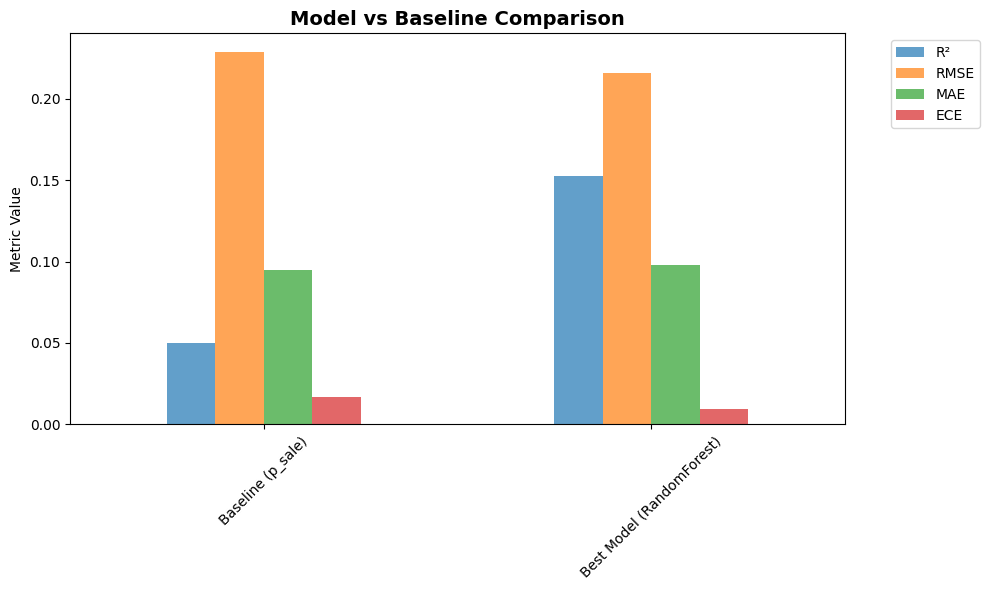

In [ ]:
# OLD CODE
# ============================================================================
# UPDATED: EXTRACT AND ANALYZE RESULTS (probabilities vs. counts, ECE by leads)
# ============================================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from generic_enrich_modeling import calculate_ece_by_leads

print("Pipeline completed successfully!")
print(f"Best model: {biz2credit_results['best_model_name']}")
print(f"Training samples: {biz2credit_results['X_train'].shape[0]:,}")
print(f"Test samples: {biz2credit_results['X_test'].shape[0]:,}")

# Get the full test set with all columns (including leads_count and p_sale)
if 'X_test_full' in biz2credit_results:
    X_test_full = biz2credit_results['X_test_full']
else:
    if 'df_biz2credit' not in globals():
        raise RuntimeError("df_biz2credit not found in globals. Please ensure the full DataFrame is available.")
    X_test_full = df_biz2credit.loc[biz2credit_results['X_test'].index]

if 'leads_count' not in X_test_full.columns:
    raise ValueError("leads_count column is missing from the test DataFrame. Cannot compute ECE by leads.")

best_model_pipeline = biz2credit_results['best_pipeline']
best_model_name = biz2credit_results['best_model_name']
X_test = biz2credit_results['X_test']
y_test = biz2credit_results['y_test']

print(f"Best Model: {best_model_name}")
print(f"Test samples: {len(y_test):,}")

# Model predictions (probabilities)
if hasattr(best_model_pipeline.named_steps['classifier'], "predict_proba"):
    y_pred_model_prob = best_model_pipeline.predict_proba(X_test)[:, 1]
elif hasattr(best_model_pipeline.named_steps['classifier'], "decision_function"):
    from scipy.special import expit
    y_pred_model_prob = expit(best_model_pipeline.decision_function(X_test))
else:
    y_pred_model_prob = best_model_pipeline.predict(X_test)

# For any downstream “class” metrics, threshold at 0.5:
y_pred_model = (y_pred_model_prob >= 0.5).astype(int)

# Baseline predictions (p_sale)
if 'p_sale' in X_test_full.columns:
    y_pred_baseline = X_test_full['p_sale'].values
else:
    raise ValueError("p_sale column is missing from the test DataFrame. Cannot compute baseline.")

leads_test = X_test_full['leads_count'].values

print("\nUPDATED ECE ANALYSIS BY LEADS COUNT")
print("="*60)

# ECE by leads (will be 0.0 if all leads_count==1)
baseline_ece = calculate_ece_by_leads(
    y_true=y_test.values,
    y_pred_prob=y_pred_baseline,
    leads_count=leads_test,
    n_bins=10,
    print_details=True,
    model_name="Baseline (p_sale)"
)
model_ece = calculate_ece_by_leads(
    y_true=y_test.values,
    y_pred_prob=y_pred_model_prob,
    leads_count=leads_test,
    n_bins=10,
    print_details=True,
    model_name="Best Model"
)

print("\nFINAL ECE COMPARISON (by leads):")
print(f"Baseline ECE: {baseline_ece:.4f}")
print(f"Model ECE: {model_ece:.4f}")
print(f"Difference: {model_ece - baseline_ece:.4f} ({'Model worse' if model_ece > baseline_ece else 'Model better'})")

print("UPDATED MODEL VS BASELINE COMPARISON")
print("="*60)

# ============================================================================
# Override metrics comparison to use probability predictions
# ============================================================================

# Ensure y_pred_model_prob already defined above

metrics_comparison = pd.DataFrame({
    'Baseline (p_sale)': [
        r2_score(y_test, y_pred_baseline),
        np.sqrt(mean_squared_error(y_test, y_pred_baseline)),
        mean_absolute_error(y_test, y_pred_baseline),
        baseline_ece
    ],
    f'Best Model ({best_model_name})': [
        r2_score(y_test, y_pred_model_prob),  # <-- use probabilities
        np.sqrt(mean_squared_error(y_test, y_pred_model_prob)),
        mean_absolute_error(y_test, y_pred_model_prob),
        model_ece
    ]
}, index=['R²', 'RMSE', 'MAE', 'ECE'])

print("\nUPDATED COMPARISON TABLE (probabilities vs. counts):")
print(metrics_comparison.round(4))

# Re-compute improvement table
improvements = pd.DataFrame({
    'Improvement': [
        metrics_comparison.loc['R²', f'Best Model ({best_model_name})'] - metrics_comparison.loc['R²', 'Baseline (p_sale)'],
        metrics_comparison.loc['RMSE', 'Baseline (p_sale)'] - metrics_comparison.loc['RMSE', f'Best Model ({best_model_name})'],
        metrics_comparison.loc['MAE', 'Baseline (p_sale)'] - metrics_comparison.loc['MAE', f'Best Model ({best_model_name})'],
        metrics_comparison.loc['ECE', 'Baseline (p_sale)'] - metrics_comparison.loc['ECE', f'Best Model ({best_model_name})']
    ],
    'Better?': [
        'Yes' if metrics_comparison.loc['R²', f'Best Model ({best_model_name})'] > metrics_comparison.loc['R²', 'Baseline (p_sale)'] else 'No',
        'Yes' if metrics_comparison.loc['RMSE', f'Best Model ({best_model_name})'] < metrics_comparison.loc['RMSE', 'Baseline (p_sale)'] else 'No',
        'Yes' if metrics_comparison.loc['MAE', f'Best Model ({best_model_name})'] < metrics_comparison.loc['MAE', 'Baseline (p_sale)'] else 'No',
        'Yes' if metrics_comparison.loc['ECE', f'Best Model ({best_model_name})'] < metrics_comparison.loc['ECE', 'Baseline (p_sale)'] else 'No'
    ]
}, index=['R² (higher=better)', 'RMSE (lower=better)', 'MAE (lower=better)', 'ECE (lower=better)'])

print("\nIMPROVEMENT ANALYSIS (updated):")
print(improvements.round(4))

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
metrics_comparison.T.plot(kind='bar', ax=ax, alpha=0.7)
ax.set_title('Model vs Baseline Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Metric Value')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# # ============================================================================
# # MODEL TRAINING - COMPARISON WITH ORIGINAL
# # ============================================================================

# # Create models for sales prediction
# models_biz = {
#     'RandomForest_Sales': RandomForestRegressor(
#         n_estimators=200, max_depth=10, min_samples_leaf=5,
#         random_state=42, n_jobs=-1
#     ),
#     'GradientBoosting_Sales': GradientBoostingRegressor(
#         n_estimators=300, learning_rate=0.05, max_depth=6,
#         subsample=0.8, random_state=42
#     ),
#     'HistGradientBoosting_Sales': HistGradientBoostingRegressor(
#         max_iter=600, learning_rate=0.05, max_depth=6,
#         l2_regularization=0.1, random_state=42
#     ),
#     'Ridge_Sales': Ridge(alpha=1.0, random_state=42)
# }

# # Evaluate regression models for sales count prediction
# print("\n=== REGRESSION MODELS WITH ENRICHMENT FEATURES ===")
# results_biz_regression = {}

# for name, model in models_biz.items():
#     print(f"\n--- Training {name} ---")
    
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor_biz),
#         ('regressor', model)
#     ])
    
#     pipeline.fit(X_train_biz, y_train_sales)
#     y_pred = pipeline.predict(X_test_biz)
    
#     # Calculate metrics
#     mse = mean_squared_error(y_test_sales, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test_sales, y_pred)
#     r2 = r2_score(y_test_sales, y_pred)
    
#     results_biz_regression[name] = {
#         'RMSE': rmse,
#         'MAE': mae,
#         'R2': r2,
#         'MSE': mse,
#         'pipeline': pipeline
#     }
    
#     print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

# # Create comparison table 
# biz_comparison_df = pd.DataFrame()
# for name, metrics in results_biz_regression.items():
#     biz_comparison_df.loc[name, 'RMSE'] = metrics['RMSE']
#     biz_comparison_df.loc[name, 'MAE'] = metrics['MAE']
#     biz_comparison_df.loc[name, 'R2'] = metrics['R2']

# print("\n" + "="*50)
# print("BIZ2CREDIT SALES PREDICTION RESULTS (WITH ENRICHMENT)")
# print("="*50)
# print(biz_comparison_df.round(4).sort_values('R2', ascending=False))


In [24]:
# # Step 3:
# print("\n=== BIZ2CREDIT MODEL TRAINING - ENRICHMENT VS ORIGINAL ===")

# # Create preprocessor for biz2credit data with imputer
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline       

# numeric_features_biz = X_train_biz.select_dtypes(include=['number']).columns
# categorical_features_biz = X_train_biz.select_dtypes(include=['object', 'category']).columns

# preprocessor_biz = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline([
#             ('imputer', SimpleImputer(strategy='median')),
#             ('scaler', RobustScaler())
#         ]), numeric_features_biz),
#         ('cat', Pipeline([
#             ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
#             ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
#         ]), categorical_features_biz)
#     ],
#     remainder='drop'
# )

In [25]:
# ### Hyperparameter tuning included: 
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint, uniform
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.pipeline import Pipeline
# import numpy as np
# import pandas as pd
# # Add Linear Regression to models
# models_biz = {
#     'RandomForest_Sales': RandomForestRegressor(
#         n_estimators=200, max_depth=10, min_samples_leaf=5,
#         random_state=42, n_jobs=-1
#     ),
#     'GradientBoosting_Sales': GradientBoostingRegressor(
#         n_estimators=300, learning_rate=0.05, max_depth=6,
#         subsample=0.8, random_state=42
#     ),
#     'HistGradientBoosting_Sales': HistGradientBoostingRegressor(
#         max_iter=600, learning_rate=0.05, max_depth=6,
#         l2_regularization=0.1, random_state=42
#     ),
#     'Ridge_Sales': Ridge(alpha=1.0, random_state=42),
#     'LinearRegression': LinearRegression()
# }

# # Evaluate regression models for sales count prediction
# print("\n=== REGRESSION MODELS WITH ENRICHMENT FEATURES ===")
# results_biz_regression = {}

# for name, model in models_biz.items():
#     print(f"\n--- Training {name} ---")
    
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor_biz),
#         ('regressor', model)
#     ])
    
#     pipeline.fit(X_train_biz, y_train_sales)
#     y_pred = pipeline.predict(X_test_biz)
    
#     # Calculate metrics
#     mse = mean_squared_error(y_test_sales, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test_sales, y_pred)
#     r2 = r2_score(y_test_sales, y_pred)
    
#     results_biz_regression[name] = {
#         'RMSE': rmse,
#         'MAE': mae,
#         'R2': r2,
#         'MSE': mse,
#         'pipeline': pipeline
#     }
    
#     print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

# # Create comparison table
# biz_comparison_df = pd.DataFrame()
# for name, metrics in results_biz_regression.items():
#     biz_comparison_df.loc[name, 'RMSE'] = metrics['RMSE']
#     biz_comparison_df.loc[name, 'MAE'] = metrics['MAE']
#     biz_comparison_df.loc[name, 'R2'] = metrics['R2']

# print("\n" + "="*50)
# print("BIZ2CREDIT SALES PREDICTION RESULTS (WITH ENRICHMENT)")
# print("="*50)
# print(biz_comparison_df.round(4).sort_values('R2', ascending=False))

# # =========================
# # Hyperparameter Tuning for Best Model (RandomForest)
# # =========================
# print("\n=== HYPERPARAMETER TUNING: RANDOM FOREST ===")

# rf_param_dist = {
#     'regressor__n_estimators': randint(100, 500),
#     'regressor__max_depth': randint(3, 20),
#     'regressor__min_samples_split': randint(2, 20),
#     'regressor__min_samples_leaf': randint(1, 10),
#     'regressor__max_features': ['sqrt','log2',None]
# }

# rf_pipeline = Pipeline([
#     ('preprocessor', preprocessor_biz),
#     ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
# ])

# rf_search = RandomizedSearchCV(
#     rf_pipeline, rf_param_dist,
#     n_iter=20, scoring='r2', n_jobs=-1, cv=3, random_state=42, verbose=1
# )
# rf_search.fit(X_train_biz, y_train_sales)


# print(f"\nBest RandomForest params: {rf_search.best_params_}")
# y_pred_rf_tuned = rf_search.predict(X_test_biz)
# rmse_rf_tuned = np.sqrt(mean_squared_error(y_test_sales, y_pred_rf_tuned))
# mae_rf_tuned = mean_absolute_error(y_test_sales, y_pred_rf_tuned)
# r2_rf_tuned = r2_score(y_test_sales, y_pred_rf_tuned)

# print(f"Tuned RandomForest - RMSE: {rmse_rf_tuned:.2f}, MAE: {mae_rf_tuned:.2f}, R²: {r2_rf_tuned:.3f}")

In [26]:
# best_rf_pipeline = rf_search.best_estimator_
# y_pred_model = best_rf_pipeline.predict(X_test_biz)

##### Model Comparing

In [ ]:
# Predict with your trained model (using all enrichment features)
y_pred_model = best_rf_pipeline.predict(X_test_biz)
y_pred_psale = X_test_biz['p_sale'].values

best_model_name = biz_comparison_df['R2'].idxmax()
best_rf_pipeline = results_biz_regression[best_model_name]['pipeline']

# After your model training/tuning cell:
best_rf_pipeline = rf_search.best_estimator_  #I did hyperparam tuning

# Now you can use it for inference:
y_pred_model = best_rf_pipeline.predict(X_test_biz)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate ECE and log loss for model and p_sale baseline
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss

def calc_ece(y_true, y_prob, n_bins=10):
    """Calculate Expected Calibration Error (ECE) for regression."""
    # For regression, we can bin the predicted values and compare mean pred vs. mean true
    bins = np.linspace(np.min(y_prob), np.max(y_prob), n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            avg_pred = y_prob[mask].mean()
            avg_true = y_true[mask].mean()
            ece += np.abs(avg_pred - avg_true) * mask.mean()
    return ece


print("=== MODEL VS. P_SALE BASELINE ON TEST DATA ===")
print("Metric         | Model      | p_sale (baseline)")
print("-" * 45)

# Model
rmse_model = np.sqrt(mean_squared_error(y_test_sales, y_pred_model))
mae_model = mean_absolute_error(y_test_sales, y_pred_model)
r2_model = r2_score(y_test_sales, y_pred_model)



# Baseline
rmse_psale = np.sqrt(mean_squared_error(y_test_sales, y_pred_psale))
mae_psale = mean_absolute_error(y_test_sales, y_pred_psale)
r2_psale = r2_score(y_test_sales, y_pred_psale)
ece_psale_val = calc_ece(y_test_sales, y_pred_psale)
logloss_psale = log_loss(y_test_sales, y_pred_psale)

print(f"RMSE           | {rmse_model:.4f}    | {rmse_psale:.4f}")
print(f"MAE            | {mae_model:.4f}    | {mae_psale:.4f}")
print(f"ECE            | {ece_model_val:.4f}    | {ece_psale_val:.4f}")
print(f"LogLoss        | {logloss_model:.4f}    | {logloss_psale:.4f}")
print(f"R²             | {r2_model:.4f}    | {r2_psale:.4f}")

# Rocket - Mortgage

In [ ]:
# rocket info
transaction_month_prt = '2025-05'
clickout_date_prt= '2025-05-01'
vertical_id = '5fa2b415c91a2010c3432900'
product_id = 3211
# partner_id = 3158

In [ ]:
def query_rocket_func() -> pd.DataFrame:  #run_id_prt:str
    query_rocket = f"""
WITH subid_data_from_enrichment_agg AS (
select subid ,
--                                      max(partner_id) as partner_id,
--                                     max(company) as company,
                                    max(case when process_name = 'quicken_rocket_leads' then 1 else 0 end)              as lead,
                                    max(case when process_name = 'quicken_rocket_allocated' then 1 else 0 end)        as allocated,
                                    max(case when process_name = 'quicken_rocket_loanamount_refi' then 1 else 0 end)        as sale,
                                    count(distinct process_name)                                                      as processes,
                                    max(case when process_name <> 'quicken_rocket_loanamount_refi' then loanamount end)  as loan_amount,
                                    max(case when process_name <> 'quicken_rocket_loanamount_refi' then creditscore end) as credit_score,
                                     max(case when process_name = 'quicken_rocket_loanamount_refi' then funded_amount end) as funded_amount,
                                    min(case when process_name = 'quicken_rocket_leads' then transaction_date end)    as min_lead_date,
                                    min(case when process_name = 'quicken_rocket_allocated' then transaction_date end)  as min_alocated_date,
                                    min(case when process_name = 'quicken_rocket_loanamount_refi' then transaction_date end)  as min_sale_date,
                                    count(*)                                                                          as rowss
                    FROM dlk_visitor_funnel_dwh_production.enrich_conversions_flatten
                    where transaction_month_prt >= '{transaction_month_prt}' --2025-03'
                    and rn = 1
                    and ( (loanpurpose = 'Refinance' and process_name in ('quicken_rocket_allocated', 'quicken_rocket_leads'))
                        OR (process_name like 'quicken_rocket_loanamount_refi')
                          )
                      and subid <> '-'
                    group by 1
),
subid_to_visitid AS (select distinct visit_iid, channel_click_id, cid
                          from dlk_visitor_funnel_dwh_production.chart_funnel
                          where vertical_id =  '{vertical_id}' --5fa2b415c91a2010c3432900'
                            and product_id = {product_id} --3211
                            and clickout_date >= DATE '{clickout_date_prt}' ), -- '2025-05-01'
     enrichmen_final as (select s.*, v.visit_iid as en_visit_iid, v.channel_click_id as en_channel_click_id
                         from subid_data_from_enrichment_agg S
                                  LEFT join subid_to_visitid v on S.SUBID = v.cid),
     prediction_data AS (SELECT channel_click_id,
                                visit_iid,
                                cid,
                                min(clickout_timestamp)      AS clickout_timestamp,
                                Max(avg_conversion_lag_lead) AS avg_conversion_lag_lead,
                                max(normalized_p_cr_lead)    AS normalized_p_cr_lead,
                                sum(normalized_p_cr_lead)    AS normalized_p_cr_lead_sum,
                                max(p_cr_lead)               AS p_cr_lead,
                                max(p_conversion_count_lead) AS p_conversion_count_lead,
                                Max(p_conversion_time_lead)  AS p_conversion_time_lead,
                                Max(avg_conversion_lag_ql)   AS avg_conversion_lag_ql,
                                max(normalized_p_cr_ql)      AS normalized_p_cr_ql,
                                max(p_conversion_count_ql)   AS p_conversion_count_ql,
                                Max(p_conversion_time_ql)    AS p_conversion_time_ql,
                                Max(avg_conversion_lag_sale) AS avg_conversion_lag_sale,
                                max(normalized_p_cr_sale)    AS normalized_p_cr_sale,
                                sum(normalized_p_cr_sale)    AS normalized_p_cr_sale_sum,
                                max(p_cr_sale)               as p_cr_sale,
                                max(p_conversion_count_sale) AS p_conversion_count_sale,
                                min(p_conversion_time_sale)  AS p_conversion_time_sale,
                                max(p_conversion_count)      AS p_conversion_count,
                                max(p_conversion_value)      AS p_conversion_value,
                                Max(model_version)           AS model_version,
                                Max(model_id)                AS model_id,
                                Max(model_run_id)            AS model_run_id,
                                Max(predicted_commission)    AS predicted_commission,
                                Max(run_id_prt)              AS run_id_prt,
                                Max(gclid)                   AS gclid,
                                Max(clickout_position)       AS clickout_position,
                                Max(pli_vertical_id)         AS pli_vertical_id,
                                Max(pli_vertical_name)       AS pli_vertical_name,
                                Max(ad_group_id)             AS ad_group_id,
                                Max(ad_group_name)           AS ad_group_name,
                                Max(agent_browser)           AS agent_browser,
                                Max(agent_os)                AS agent_os,
                                Max(agent_platform)          AS agent_platform,
                                Max(bidded_keyword)          AS bidded_keyword,
                                Max(campaign_id)             AS campaign_id,
                                Max(campaign_name)           AS campaign_name,
                                Max(channel_country_code)    AS channel_country_code,
                                Max(channel_region_code)     AS channel_region_code,
                                Max(landing_page_uri)        AS landing_page_uri,
                                Max(match_type)              AS match_type,
                                Max(pli_segment_id)          AS pli_segment_id,
                                Max(pli_segment_name)        AS pli_segment_name,
                                Max(product_id)              AS product_id,
                                Max(product_name)            AS product_name,
                                Max(source_join)             AS source_join,
                                Max(topic)                   AS topic,
                                Max(utm_source)              AS utm_source,
                                Max(visit_timestamp)         AS visit_timestamp,
                                max(estimated_earnings_usd)  AS estimated_earnings_usd,
                                max(estimated_conversions)   AS estimated_conversions,
                                max(conversion_count)        AS conversion_count,
                                Max(user_id)                 AS user_id,
                                max(leads_count)             AS leads_count,
                                max(qualified_leads_count)   AS qualified_leads_count,
                                max(sales_count)             AS sales_count,
                                Max(bucket_group)            AS bucket_group,
                                Max(ppc_account_name)        AS ppc_account_name,
                                Max(vertical_id)             AS vertical_id,
                                Max(traffic_source_name)     AS traffic_source_name,
                                Max(company)                 AS company,
                                Max(traffic_join)            AS traffic_join,
                                Max(ppc_account_id)          AS ppc_account_id,
                                Max(country_code)            AS country_code,
                                Max(ip_region_code)          AS ip_region_code,
                                Max(channel_click_id_source) AS channel_click_id_source,
                                Max(site_id)                 AS site_id,
                                Max(site_name)               AS site_name,
--                                 Max(partner_id)              AS partner_id,
--                                 Max(partner_name)            AS partner_name,
                                Max(out_type)                AS out_type,
                                Max(page_type_name)          AS page_type_name,
                                min(clickout_date_prt)       AS clickout_date_prt,
                                min(conversion_month_prt)    AS conversion_month_prt
                         FROM dlk_mlmodels_production.v_multilabel_conversions_predictions_fast_longer
                         WHERE product_id = {product_id}
                           AND vertical_id = '{vertical_id}'
                           and clickout_date_prt >= '{clickout_date_prt}'
                         group by channel_click_id, visit_iid,cid
                         )
select p.*, en.*
from prediction_data as p
inner join enrichmen_final as en
on (p.channel_click_id = en.en_channel_click_id and p.visit_iid = en.en_visit_iid and p.cid = en.subid)
where p.leads_count >= 1

    """
    raw = AthenaApi().execute_fetch(query_rocket)
    df_rocket_enrich = pd.DataFrame(raw)
    return df_rocket_enrich

df_rocket_enrich = query_rocket_func()
df_rocket_enrich.head()

In [ ]:
df_rocket_enrich.partner_name.describe()

In [ ]:
# a1 = df_rocket_enrich.groupby('subid').sale
# a1.head()
# a1 = a1.to_frame()
df_rocket_enrich.funded_amount.fillna(0, inplace=True)
df_rocket_enrich.funded_amount.describe()

big_subids = df_rocket_enrich[df_rocket_enrich.sale >= 1].index
len(big_subids)

df_rocket_enrich[df_rocket_enrich['subid'].isin(big_subids)].sales_count.sum()  #.sales_count.sum()
df_rocket_enrich[df_rocket_enrich['credit_score'].isnull()].sort_values(by='clickout_timestamp')
df_rocket_enrich.isnull().sum() / df_rocket_enrich.count().round(3)  #.sort_values(ascending=False)

# df_rocket_enrich = df_rocket_enrich.drop(columns=['predicted_commission'])
print('col predicted_commission has removed')

print('describe:')
print(df_rocket_enrich.describe())
print('info:')
print(df_rocket_enrich.info())
print('shape:')
print(df_rocket_enrich.shape)
df_rocket_enrich.commission.value_counts()
# df_rocket_enrich.columns

In [ ]:
sales_rocket_enrich = df_rocket_enrich.loc[df_rocket_enrich.sale >= 1]
sales_rocket_enrich.groupby('credit_score')[['loan_amount', 'funded_amount']].agg(['mean','sum'])
# pd.set_option('display.float_format', '{:,.1f}'.format)
# df_rocket_enrich.groupby('commission')[
#     ['application_annual_revenue', 'age_of_business_months', 'application_annual_revenue']].agg(['mean', 'sum'])
# pd.set_option('display.float_format', '{:,.2f}'.format)
# df_rocket_enrich.groupby('commission')[['application_annual_revenue', 'age_of_business_months']].mean()